<a href="https://colab.research.google.com/github/BickNutler/Springboard/blob/main/Clustering_Case_Study_Customer_Segmentation_with_K_Means_Tier_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NOTE: This project was completed with the assistance of Google Colab and its built in Gemini AI.**

# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling**
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [4]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers

offer_id   campaign            varietal  min_qty  discount        origin  \
0          1    January              Malbec       72        56        France   
1          2    January          Pinot Noir       72        17        France   
2          3   February           Espumante      144        32        Oregon   
3          4   February           Champagne       72        48        France   
4          5   February  Cabernet Sauvignon      144        44   New Zealand   
5          6      March            Prosecco      144        86         Chile   
6          7      March            Prosecco        6        40     Australia   
7          8      March           Espumante        6        45  South Africa   
8          9      April          Chardonnay      144        57         Chile   
9         10      April            Prosecco       72        52    California   
10        11        May           Champagne       72        85        France   
11        12        May            Prosecco       72        83     Australia   
12        13        May              Merlot        6        43         Chile   
13        14       June              Merlot       72        64         Chile   
14        15       June  Cabernet Sauvignon      144        19         Italy   
15        16       June              Merlot       72        88    California   
16        17       July          Pinot Noir       12        47       Germany   
17        18       July           Espumante        6        50        Oregon   
18        19       July           Champagne       12        66       Germany   
19        20     August  Cabernet Sauvignon       72        82         Italy   
20        21     August           Champagne       12        50    California   
21        22     August           Champagne       72        63        France   
22        23  September          Chardonnay      144        39  South Africa   
23        24  September          Pinot Noir        6        34         Italy   
24        25    October  Cabernet Sauvignon       72        59        Oregon   
25        26    October          Pinot Noir      144        83     Australia   
26        27    October           Champagne       72        88   New Zealand   
27        28   November  Cabernet Sauvignon       12        56        France   
28        29   November        Pinot Grigio        6        87        France   
29        30   December              Malbec        6        54        France   
30        31   December           Champagne       72        89        France   
31        32   December  Cabernet Sauvignon       72        45       Germany   

    past_peak  
0       False  
1       False  
2        True  
3        True  
4        True  
5       False  
6        True  
7       False  
8       False  
9       False  
10      False  
11      False  
12      False  
13      False  
14      False  
15      False  
16      False  
17      False  
18      False  
19      False  
20      False  
21      False  
22      False  
23      False  
24       True  
25      False  
26      False  
27       True  
28      False  
29      False  
30      False  
31       True

In [5]:
df_offers.shape

(32, 7)

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [6]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

In [7]:
df_transactions.shape

(324, 3)

In [8]:
# Count the number of unique customer names
unique_customer_count = df_transactions['customer_name'].nunique()
print(f"Number of unique customer names: {unique_customer_count}")

Number of unique customer names: 100


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [9]:
# Merge the two dataframes so we can figure out which customer responded to which offer
df = pd.merge(df_transactions, df_offers)

# Create a pivot table
# The 'customer_name' column will be the index
# The 'offer_id' column will be the new columns
# The 'n' column (which is 1) will be the values, indicating a response
# fill_value=0 will handle NaN values by replacing them with 0, meaning the customer did not respond to that offer
df = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n').fillna(0)

df = df.reset_index(drop=False)
df.index.name = None

display(df.head())
df.shape

offer_id customer_name    1    2    3    4    5    6    7    8    9  ...   23  \
0                Adams  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1                Allen  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   
2             Anderson  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3               Bailey  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   
4                Baker  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   

offer_id   24   25   26   27   28   29   30   31   32  
0         0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
1         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
2         1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
3         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 33 columns]

(100, 33)

## 3. Modelling
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned.

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly.

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p>
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix.
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

SS is the sum of squared distances between each data point and the data point's cluster's centroid or mean. When creating our clusters, we evaluate them based on their variance which is closely related to each points average distance from the mean. Since lower variance means better clustering (assuming we arent over fitting and have more clusters than there are true groupings for the data), then a lower SS will also represent better clustering.

In [10]:
# your turn

# Create a numpy matrix x_cols with only the columns representing the offers (i.e. the 0/1 columns)
# We need to drop the 'index' and 'customer_name' columns to isolate the offer data
x_cols = df.drop(columns=['customer_name']).values

# Display the shape and a few rows of x_cols to verify
print("Shape of x_cols:", x_cols.shape)
print("First 5 rows of x_cols:\n", x_cols[:5])

Shape of x_cols: (100, 32)
First 5 rows of x_cols:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]]


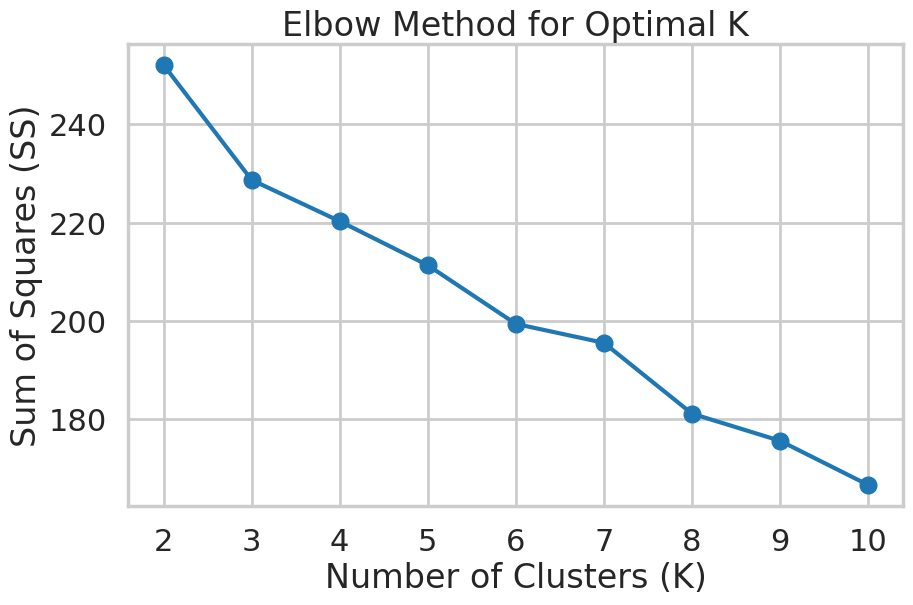

In [11]:
# Initialize an empty list to store the sum of squares for each K
ss = []
k_values = list(range(2, 11))

# Loop through different values of K (number of clusters)
for k in k_values:
    # Create a KMeans instance with random_state for reproducibility
    # The n_init='auto' handles the warning for default n_init changing from 10 to 'auto'
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    # Fit KMeans to the x_cols matrix
    kmeans.fit(x_cols)
    # Append the sum of squares (inertia) to the list
    ss.append(kmeans.inertia_)

# Plot SS for each K
plt.figure(figsize=(10, 6))
plt.plot(k_values, ss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of Squares (SS)")
plt.title("Elbow Method for Optimal K")
plt.xticks(k_values)
plt.grid(True)
plt.show()

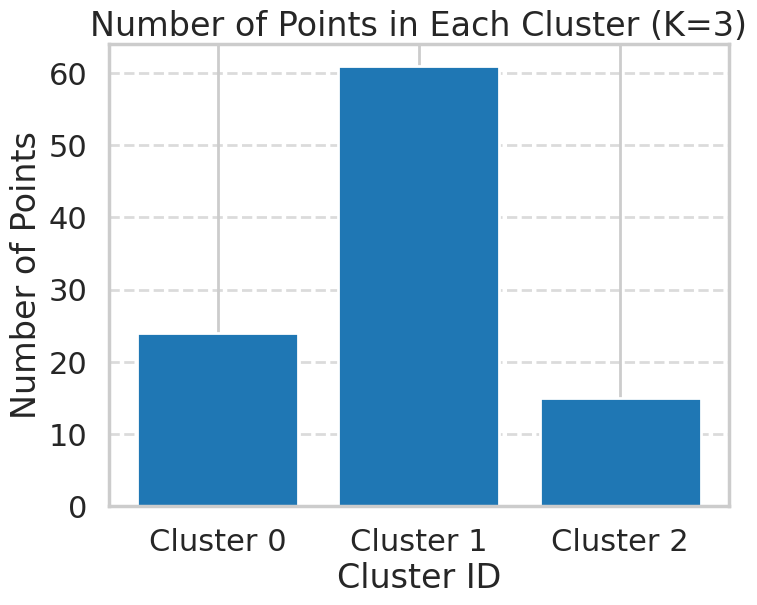

In [12]:
# Choose a 'best K' based on the Elbow method plot (for this example, we'll choose K=3)
# In a real scenario, you would inspect the plot from the previous cell to make this choice.
best_k = 3

# Apply KMeans with the chosen best_k
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
kmeans_best.fit(x_cols)

# Get the cluster labels for each data point
cluster_labels = kmeans_best.labels_

# Count the number of points in each cluster
# np.bincount is efficient for counting non-negative integers
cluster_counts = np.bincount(cluster_labels)

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(best_k), cluster_counts, tick_label=[f'Cluster {i}' for i in range(best_k)])
plt.xlabel("Cluster ID")
plt.ylabel("Number of Points")
plt.title(f"Number of Points in Each Cluster (K={best_k})")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

I chose a K value of 3 in this case because the largest drop off in SS was from 2 to 3, but the "best" K value, or number of clusters, is always going to depend on the application and the exact scenario in which the clustering is used. Using the elbow method in this scenario was not very optimal as we only have a very slight bend at K=3, ideally we would see a curve with more concavity to it. For this case our "arm" is almost completey straight.

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2, the average silhouette_score is : 0.083


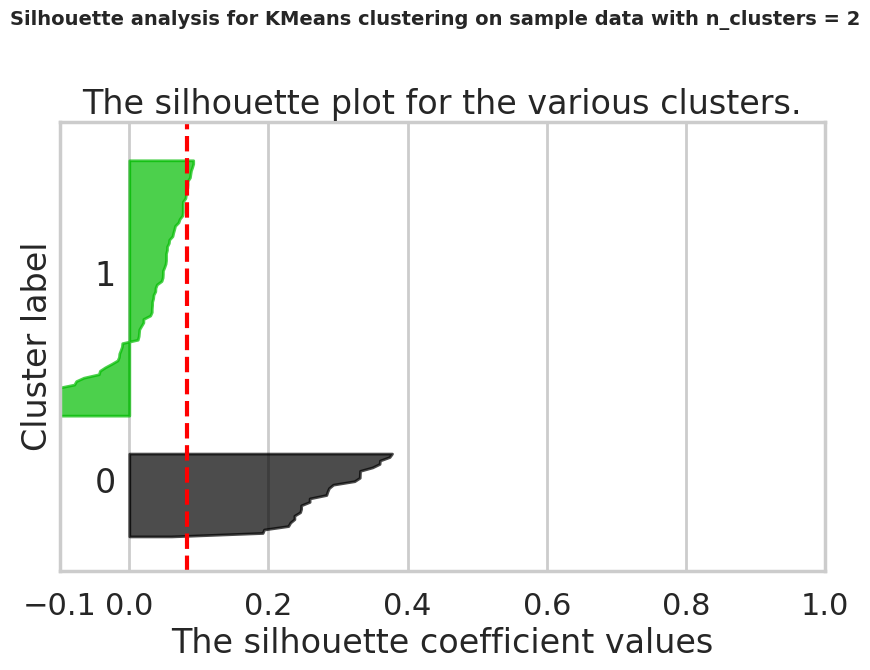

For n_clusters = 3, the average silhouette_score is : 0.111


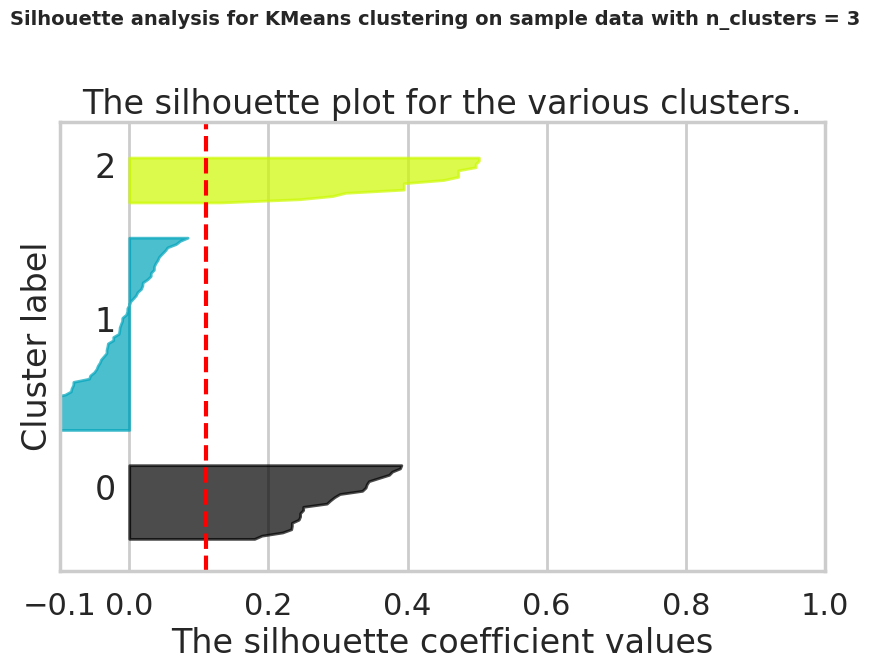

For n_clusters = 4, the average silhouette_score is : 0.090


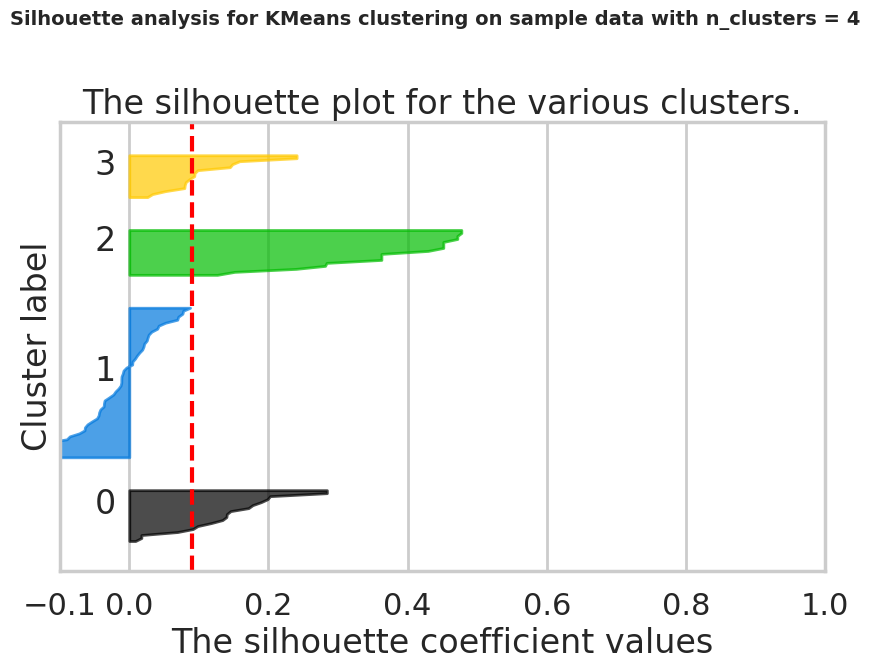

For n_clusters = 5, the average silhouette_score is : 0.092


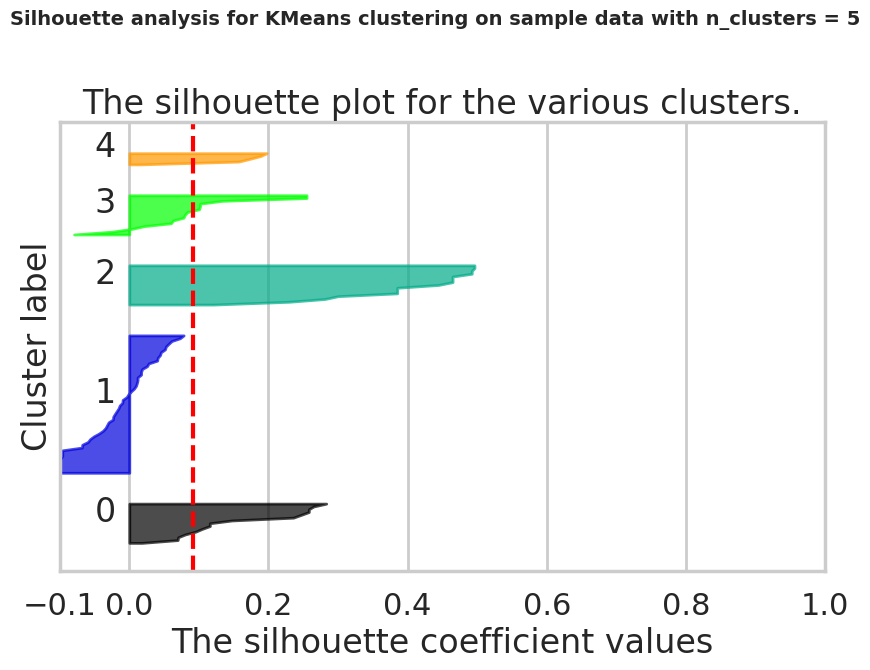

For n_clusters = 6, the average silhouette_score is : 0.102


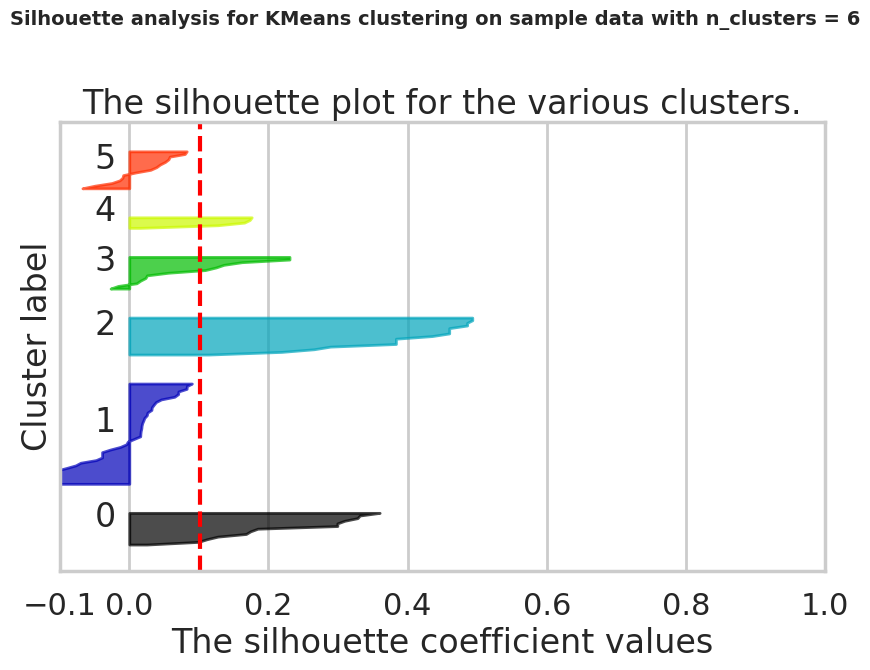

For n_clusters = 7, the average silhouette_score is : 0.073


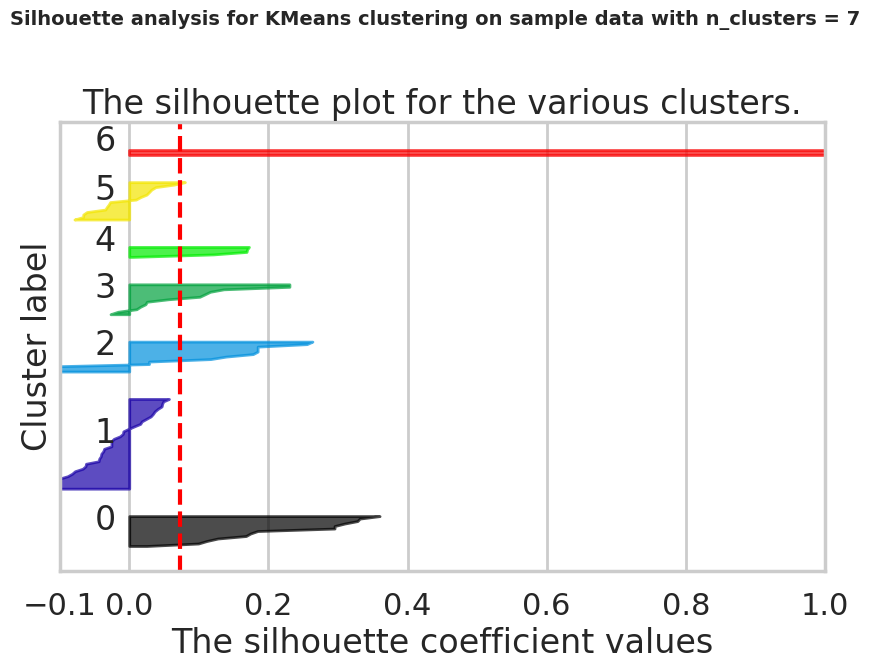

For n_clusters = 8, the average silhouette_score is : 0.113


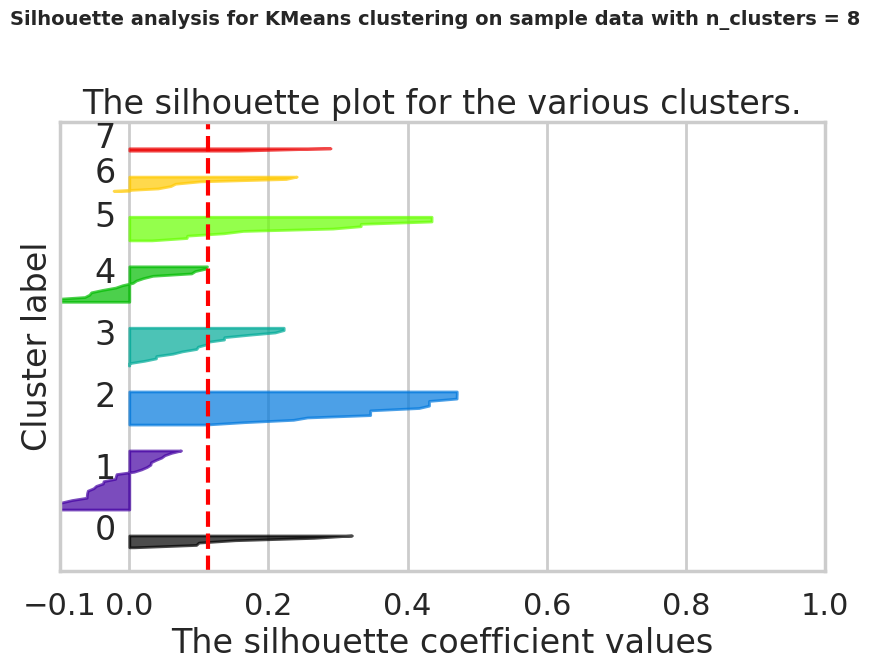

For n_clusters = 9, the average silhouette_score is : 0.112


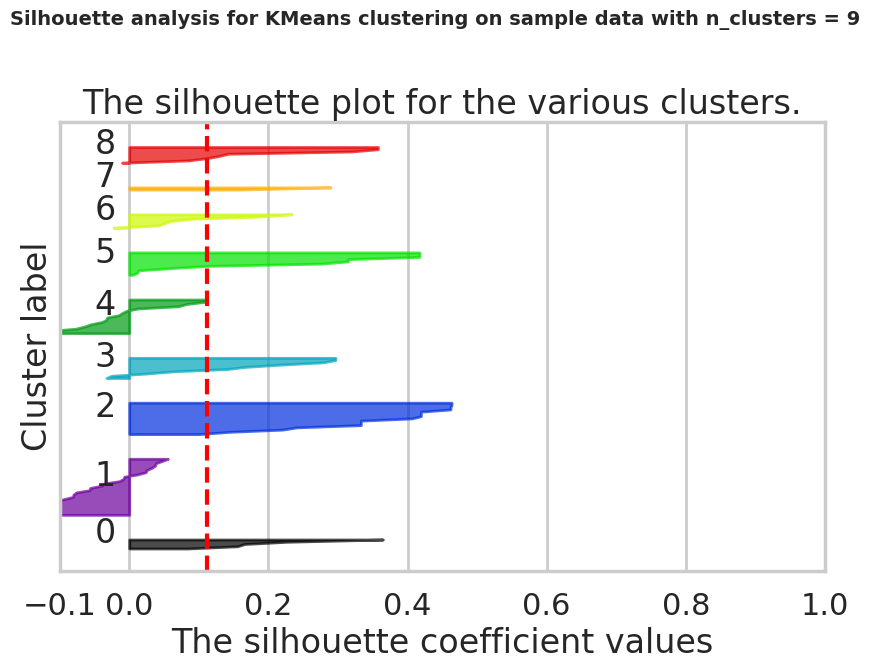

For n_clusters = 10, the average silhouette_score is : 0.121


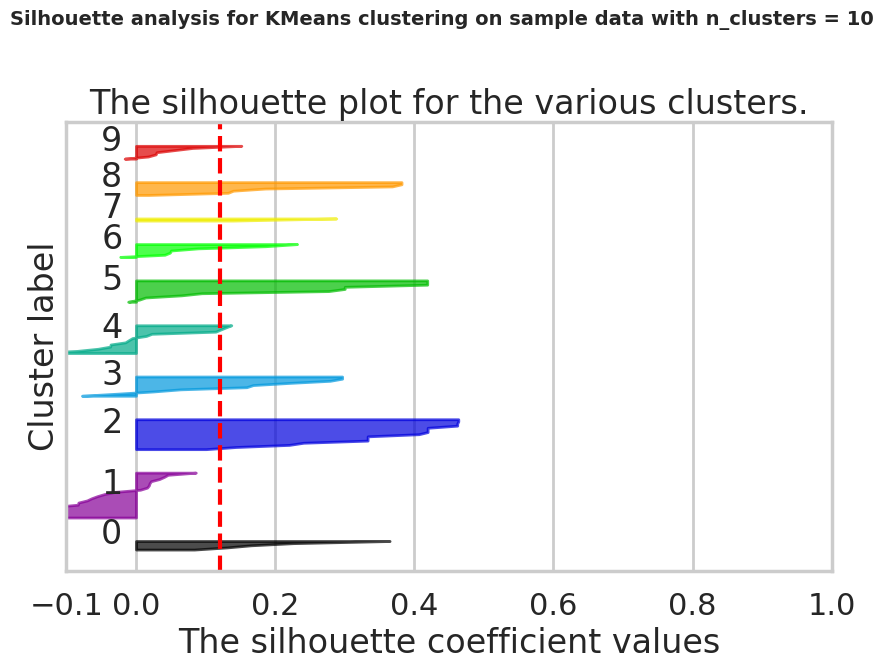

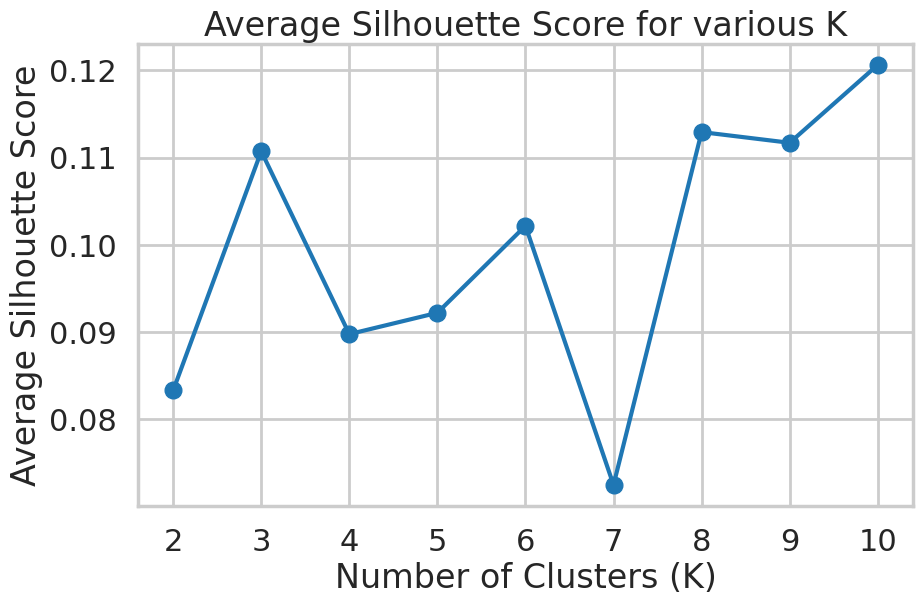

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Range of K values to test
k_range = range(2, 11)

avg_silhouette_scores = []

for k in k_range:
    fig, ax1 = plt.subplots(1, 1, figsize=(9, 7))
    fig.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {k}", fontsize=14, fontweight='bold')

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # values are positive (i.e. larger than 0)
    ax1.set_xlim([-0.1, 1])
    # The (k+1)*10 is to insert blank space between silhouette plots of individual clusters,
    # to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (k + 1) * 10])

    # Initialize the clusterer with k clusters and a random seed
    clusterer = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg:.3f}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.tight_layout()
    plt.show()

# Plot the average silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, avg_silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Average Silhouette Score")
plt.title("Average Silhouette Score for various K")
plt.xticks(k_range)
plt.grid(True)
plt.show()

Assuming we are only using K values between 2 and 10, then our highest average silhouette score comes from a k value of 10, but its hard to say based on this alone if 10 clusters is "better" than the other cluster counts, without having a better understanding of our relationship between our variables. If we want to minimize our number of clusters though, we want to choose a local maximum for our silhouette score, which would be

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

In [14]:
from sklearn.preprocessing import MinMaxScaler

def calculate_gap_statistic(data, k_min, k_max, B=10):
    """
    Calculates the Gap Statistic for K-Means clustering.

    Args:
        data (numpy.ndarray): The feature matrix (e.g., x_cols).
        k_min (int): The minimum number of clusters to test.
        k_max (int): The maximum number of clusters to test.
        B (int): The number of reference datasets to generate.

    Returns:
        tuple: A tuple containing:
            - list: Gap Statistics (G_k) for each K.
            - list: Standard deviations (s_k) for each K.
            - int: The optimal K value.
    """
    ss_original = []
    log_ss_original = []
    gaps = []
    s_k_values = []

    # 4. Create a MinMaxScaler object and fit it to your data to define bounds
    scaler = MinMaxScaler()
    scaler.fit(data)
    data_min = scaler.data_min_
    data_max = scaler.data_max_

    # 5. Loop through K values from k_min to k_max (inclusive)
    for k in range(k_min, k_max + 1):
        print(f"Calculating for K = {k}...")
        # a. For the current K, initialize and fit KMeans to original data
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(data)
        inertia = kmeans.inertia_

        # b. Append the inertia and its logarithm to respective lists
        ss_original.append(inertia)
        log_ss_original.append(np.log(inertia))

        # c. Initialize an empty list for log of sum of squares for reference datasets
        log_ss_reference = []

        # d. Loop B times to generate reference datasets
        for _ in range(B):
            # i. Generate a reference dataset by creating uniform random data
            #    between the min and max values of each feature in original dataset.
            #    Shape should be the same as original data.
            random_data = np.random.uniform(low=data_min, high=data_max, size=data.shape)

            # ii. Fit a new KMeans model to this reference data and append its log inertia
            kmeans_ref = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans_ref.fit(random_data)
            log_ss_reference.append(np.log(kmeans_ref.inertia_))

        # e. Calculate the average of log_ss_reference
        E_n_log_SS = np.mean(log_ss_reference)

        # f. Calculate the Gap Statistic G_k
        G_k = E_n_log_SS - log_ss_original[-1]

        # g. Calculate the standard deviation of the log_ss_reference values
        sd_log_ss_reference = np.std(log_ss_reference)

        # h. Calculate s_k
        s_k = sd_log_ss_reference * np.sqrt(1 + 1.0 / B) # Using 1.0 for float division clarity

        # i. Append G_k to gaps and s_k to s_k_values
        gaps.append(G_k)
        s_k_values.append(s_k)

    # 6. Identify the optimal K
    optimal_k = None
    for k_idx in range(len(gaps) - 1):
        current_k_val = k_min + k_idx
        # Check the condition G_k >= G_{k+1} - s_{k+1}
        if gaps[k_idx] >= gaps[k_idx + 1] - s_k_values[k_idx + 1]:
            optimal_k = current_k_val
            break
    # If the condition is never met, often the largest K is considered optimal, or further analysis is needed.
    # For this exercise, we'll assign the last K if no 'elbow' is found based on the condition.
    if optimal_k is None:
        optimal_k = k_max

    # 7. Print the results
    print("\nGap Statistics (G_k) and their standard deviations (s_k):")
    for i, k_val in enumerate(range(k_min, k_max + 1)):
        print(f"K={k_val}: G_k = {gaps[i]:.4f}, s_k = {s_k_values[i]:.4f}")
    print(f"\nIdentified Optimal K: {optimal_k}")

    return gaps, s_k_values, optimal_k

# Call the function with x_cols and the specified K range
gaps, s_k_values, optimal_k = calculate_gap_statistic(x_cols, k_min=2, k_max=10, B=100)

Calculating for K = 2...
Calculating for K = 3...
Calculating for K = 4...
Calculating for K = 5...
Calculating for K = 6...
Calculating for K = 7...
Calculating for K = 8...
Calculating for K = 9...
Calculating for K = 10...

Gap Statistics (G_k) and their standard deviations (s_k):
K=2: G_k = -0.0014, s_k = 0.0161
K=3: G_k = 0.0620, s_k = 0.0179
K=4: G_k = 0.0689, s_k = 0.0161
K=5: G_k = 0.0870, s_k = 0.0199
K=6: G_k = 0.1198, s_k = 0.0191
K=7: G_k = 0.1172, s_k = 0.0186
K=8: G_k = 0.1684, s_k = 0.0197
K=9: G_k = 0.1794, s_k = 0.0207
K=10: G_k = 0.2131, s_k = 0.0190

Identified Optimal K: 3


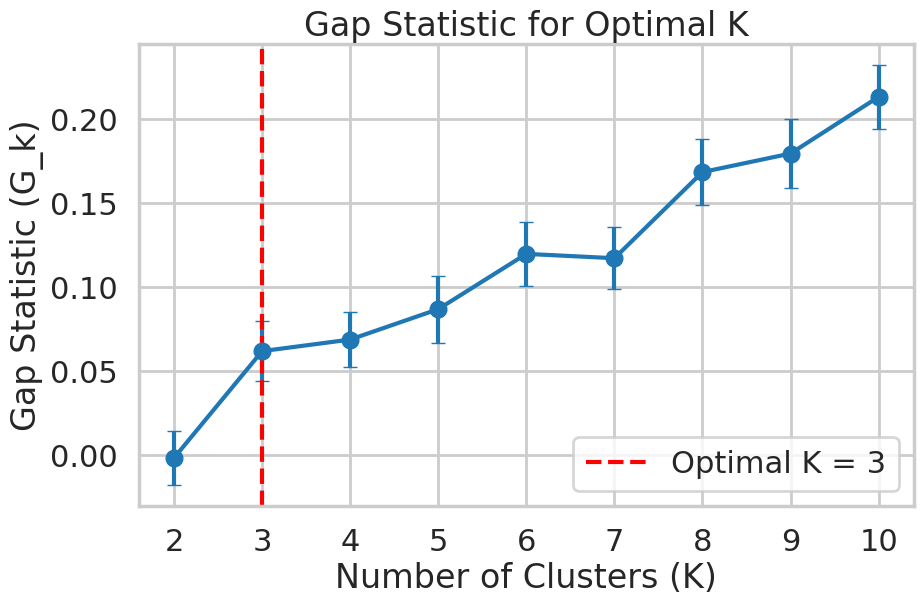

In [15]:
import matplotlib.pyplot as plt

# Create a list of K values corresponding to the calculated gaps
k_values = list(range(2, 11))

# Plot the Gap Statistics with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, gaps, yerr=s_k_values, fmt='-o', capsize=5)

# Label the axes and add a title
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Gap Statistic (G_k)")
plt.title("Gap Statistic for Optimal K")
plt.xticks(k_values)

# Highlight the optimal K value
if optimal_k is not None:
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
    plt.legend()

# Add a grid for better readability
plt.grid(True)

# Display the plot
plt.show()


#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/).

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look?
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [16]:
from sklearn.decomposition import PCA

# Instantiate PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the x_cols matrix and transform it
pca_components = pca.fit_transform(x_cols)

pca_df = pd.DataFrame({
    'x': pca_components[:, 0],
    'y': pca_components[:, 1]
})

# Display the shape of the resulting components to verify
print("Shape of PCA components:", pca_components.shape)
print("First 5 rows of PCA components:\n", pca_components[:5])

Shape of PCA components: (100, 2)
First 5 rows of PCA components:
 [[ 1.00757996  0.10821467]
 [-0.28753924  0.04471451]
 [-0.39203204  1.03839141]
 [ 0.69947727 -0.02254222]
 [ 0.08818322 -0.47169543]]


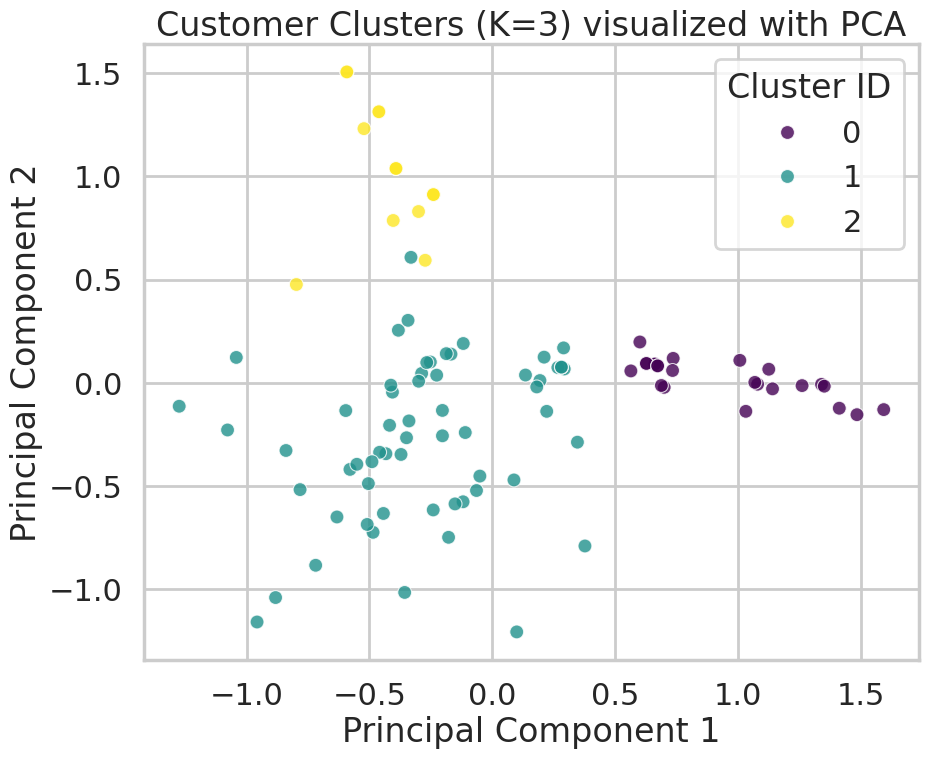

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import pandas as pd

# Re-apply KMeans with the 'best_k' identified earlier (best_k = 3)
# Ensure x_cols is available from previous steps
# If x_cols is not defined in the current scope, you would need to define it as:
# x_cols = df.drop(columns=['customer_name']).values

kmeans_for_plot = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
cluster_labels_for_plot = kmeans_for_plot.fit_predict(x_cols)

# Create a DataFrame for plotting that includes customer_name, cluster_id, and PCA components
plot_df = pd.DataFrame({
    "customer_name": df['customer_name'],
    "cluster_id": cluster_labels_for_plot,
    "x": pca_components[:, 0],
    "y": pca_components[:, 1]
})

# Plot the scatterplot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=plot_df,
    x="x",
    y="y",
    hue="cluster_id",
    palette="viridis", # 'viridis' is a good choice for categorical data
    s=100,             # Marker size
    alpha=0.8          # Transparency
)
plt.title(f"Customer Clusters (K={best_k}) visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster ID")
plt.grid(True)
plt.show()


In [18]:
# First, create a mapping of customer name to cluster ID
customer_cluster_map = plot_df[['customer_name', 'cluster_id']].drop_duplicates()

# Merge df_transactions with the customer_cluster_map to add cluster_id to transactions
merged_data = pd.merge(df_transactions, customer_cluster_map, on='customer_name')

# Finally, merge with df_offers to get all the original offer details along with cluster_id
final_df = pd.merge(merged_data, df_offers, on='offer_id')

# Display the head of the new DataFrame and its shape
display(final_df)
print(f"Shape of the final DataFrame: {final_df.shape}")

customer_name  offer_id  n  cluster_id   campaign            varietal  \
0           Smith         2  1           2    January          Pinot Noir   
1           Smith        24  1           2  September          Pinot Noir   
2         Johnson        17  1           2       July          Pinot Noir   
3         Johnson        24  1           2  September          Pinot Noir   
4         Johnson        26  1           2    October          Pinot Noir   
..            ...       ... ..         ...        ...                 ...   
319        Fisher        11  1           1        May           Champagne   
320        Fisher        22  1           1     August           Champagne   
321        Fisher        28  1           1   November  Cabernet Sauvignon   
322        Fisher        30  1           1   December              Malbec   
323        Fisher        31  1           1   December           Champagne   

     min_qty  discount     origin  past_peak  
0         72        17     France      False  
1          6        34      Italy      False  
2         12        47    Germany      False  
3          6        34      Italy      False  
4        144        83  Australia      False  
..       ...       ...        ...        ...  
319       72        85     France      False  
320       72        63     France      False  
321       12        56     France       True  
322        6        54     France      False  
323       72        89     France      False  

[324 rows x 10 columns]

Shape of the final DataFrame: (324, 10)


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

We can see that the total lot of points on the scatter plot has one large amorphous region and two rough lines of point that extend out, where the large body represents cluster 1 and the two lines extending out represent cluster 0 and 2.

Visually, I think it is safe to say that 3 clusters are best representative of the data, seperating the plot into three discint point clouds.

Based on my interpretation of the three methods, I found K=3 to be the optimal K for all 3, but technically, using the silhouette method for K values between 2 and 10 resulted in 10 being the optimal K for that method, but considering that would almost certainly have resulted in overfitting clusters on the data, I believe 3 to be the optimal K here.


--- Analysis for Cluster ID: 0 (Total customers: 24) ---


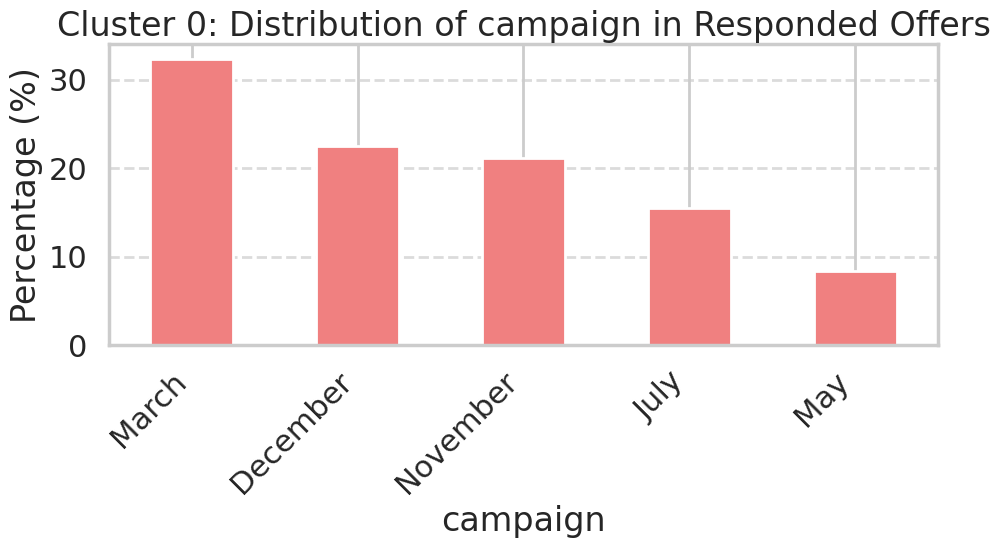

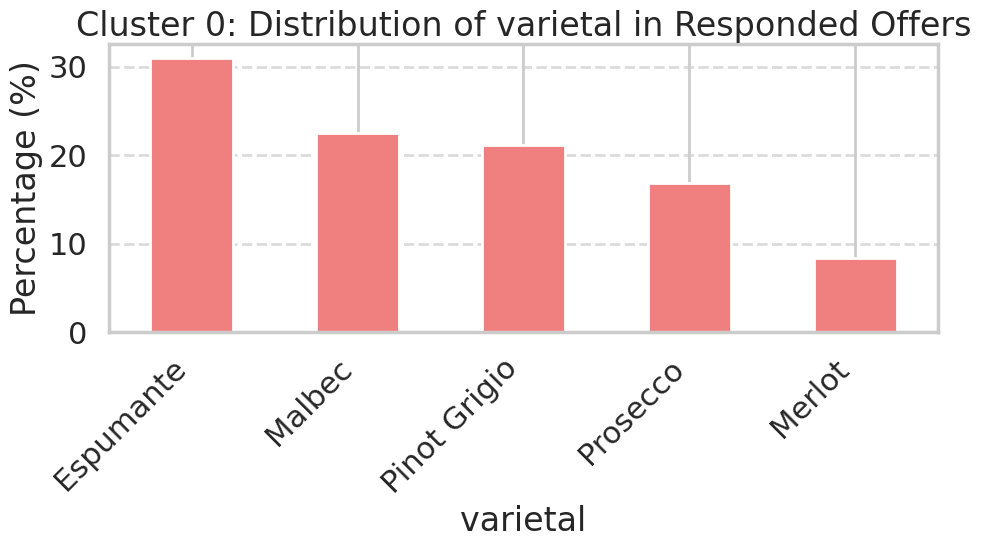

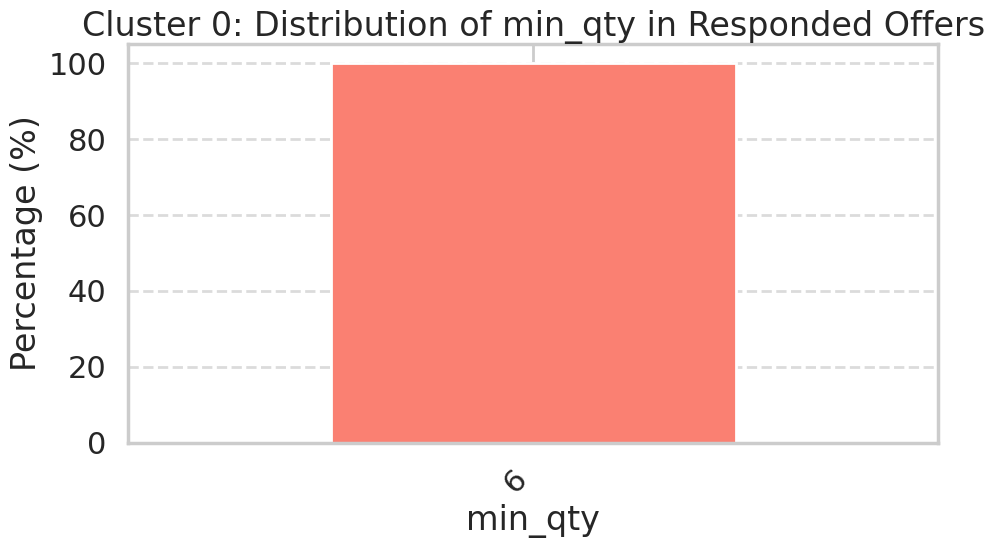

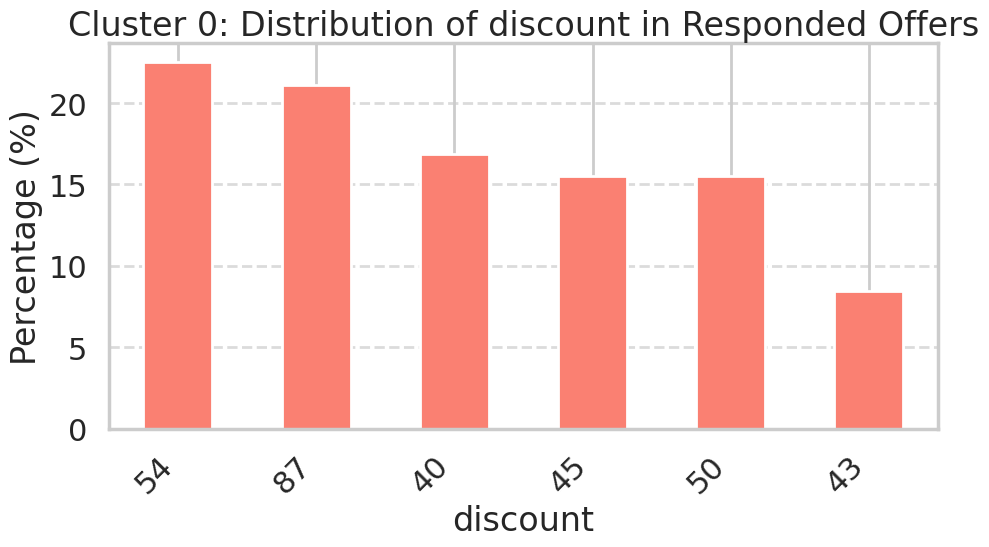

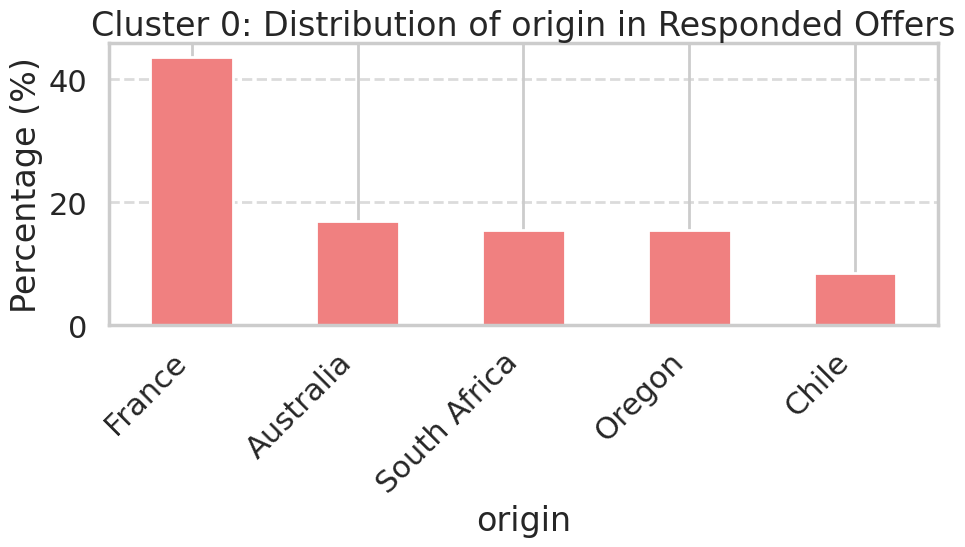

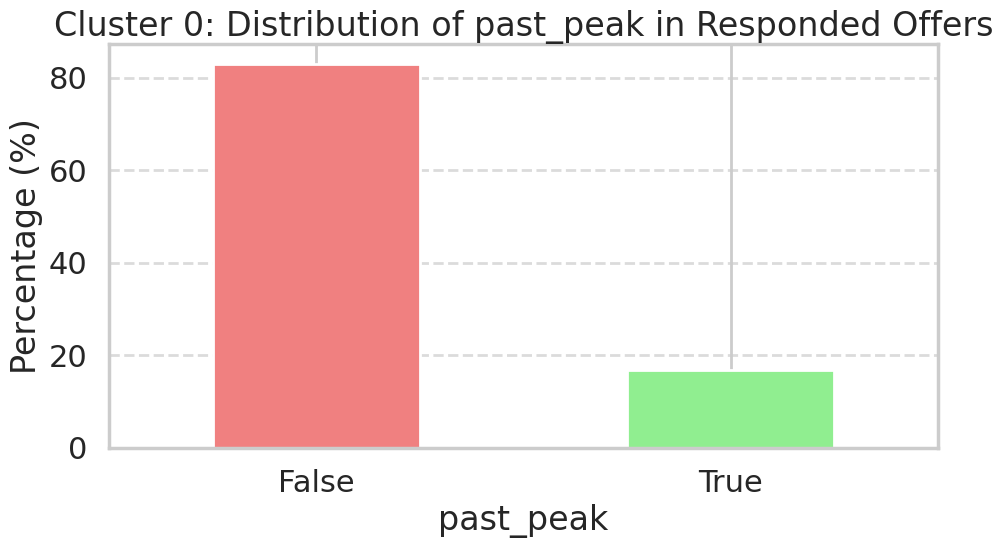


--- Analysis for Cluster ID: 1 (Total customers: 61) ---


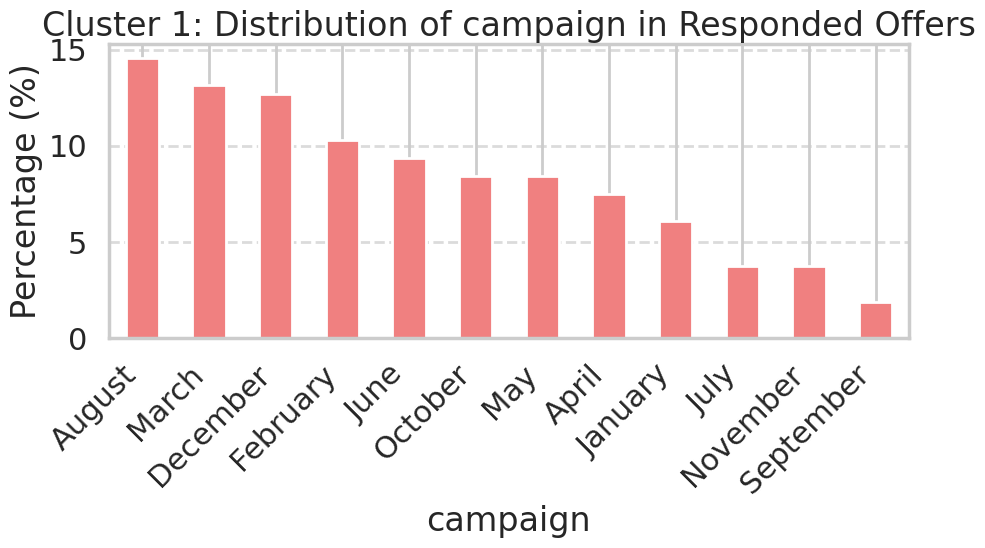

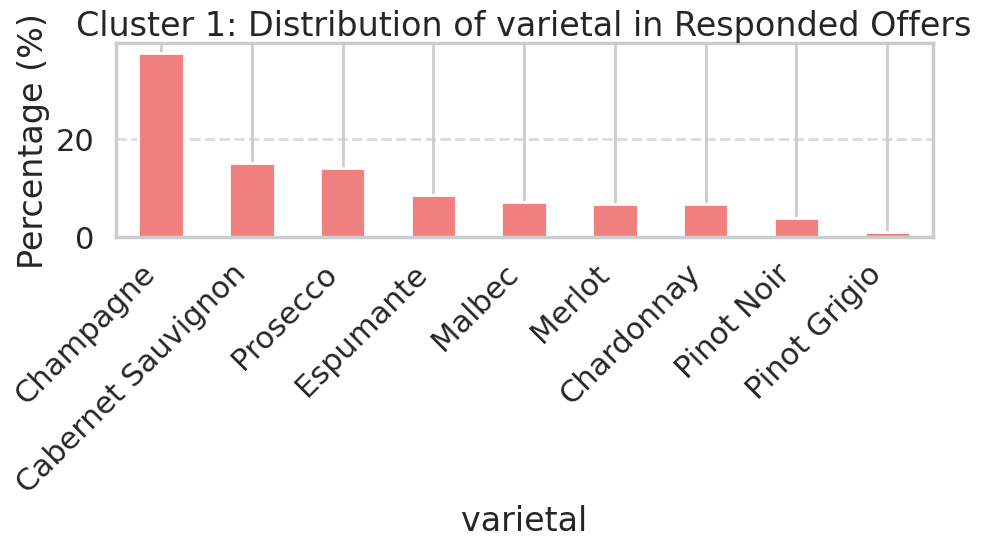

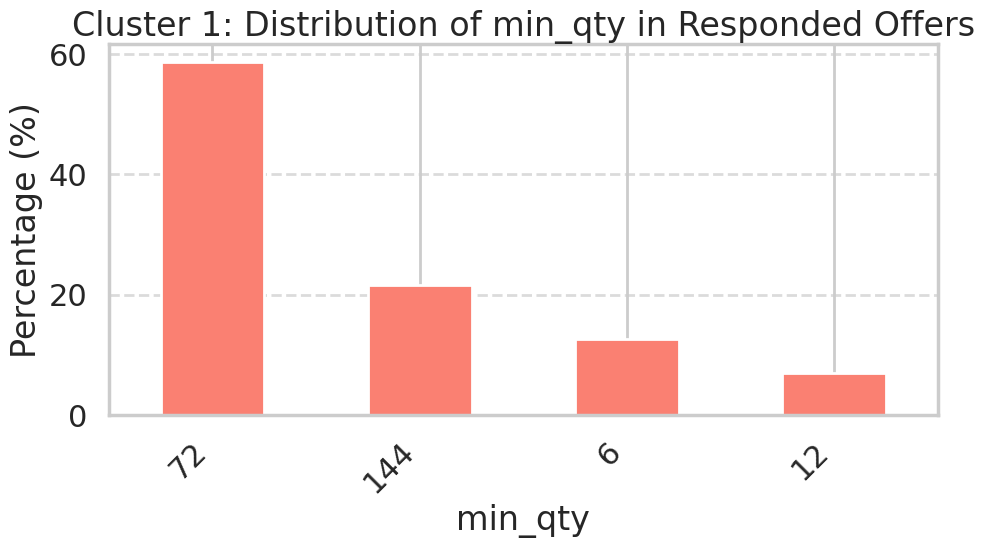

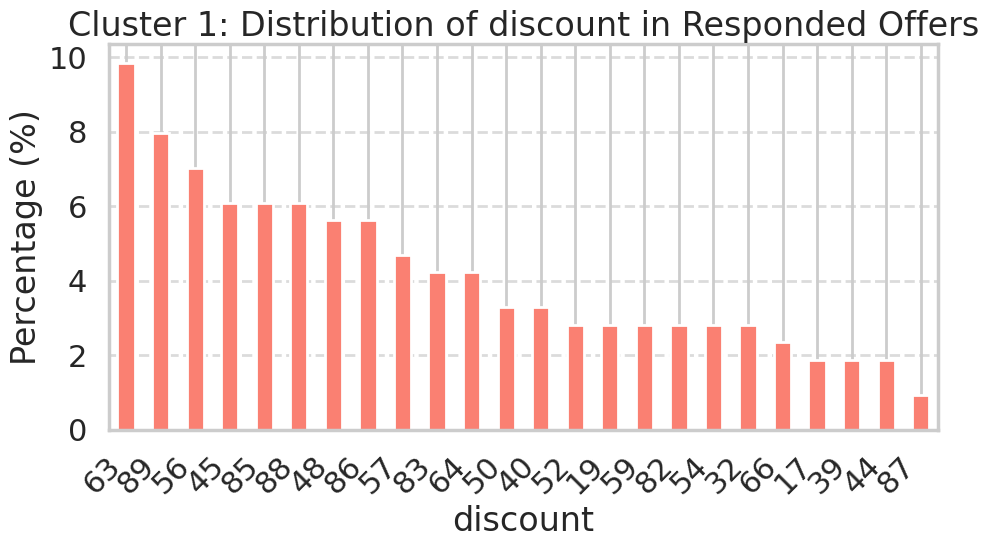

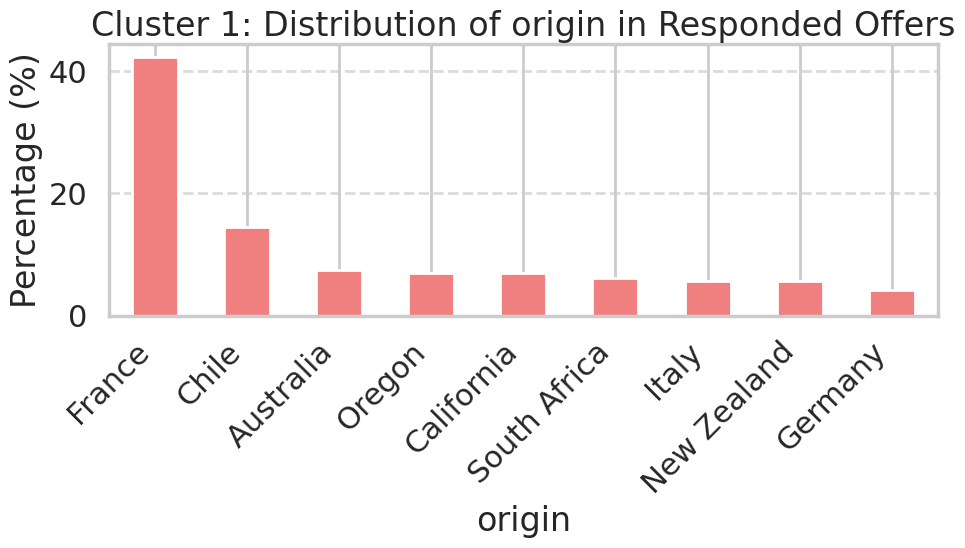

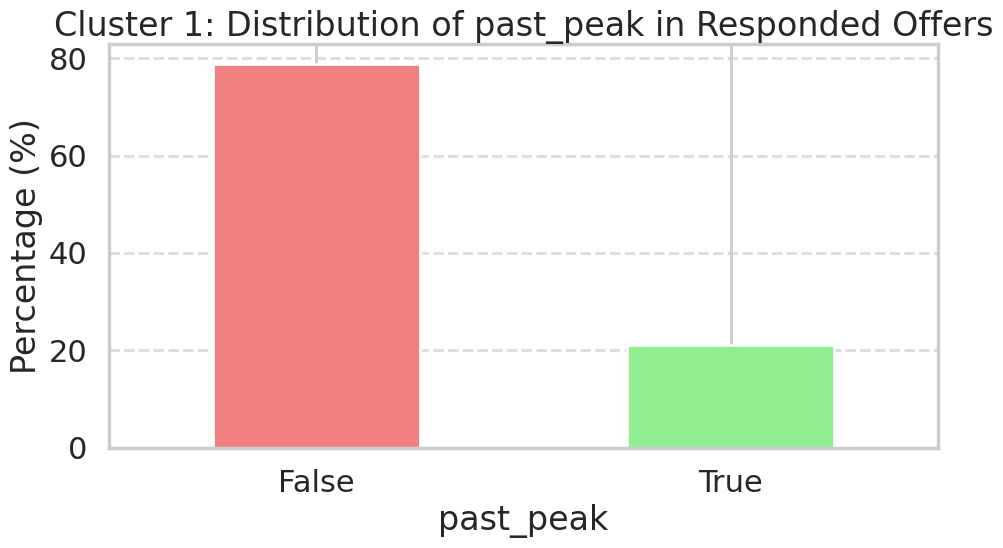


--- Analysis for Cluster ID: 2 (Total customers: 15) ---


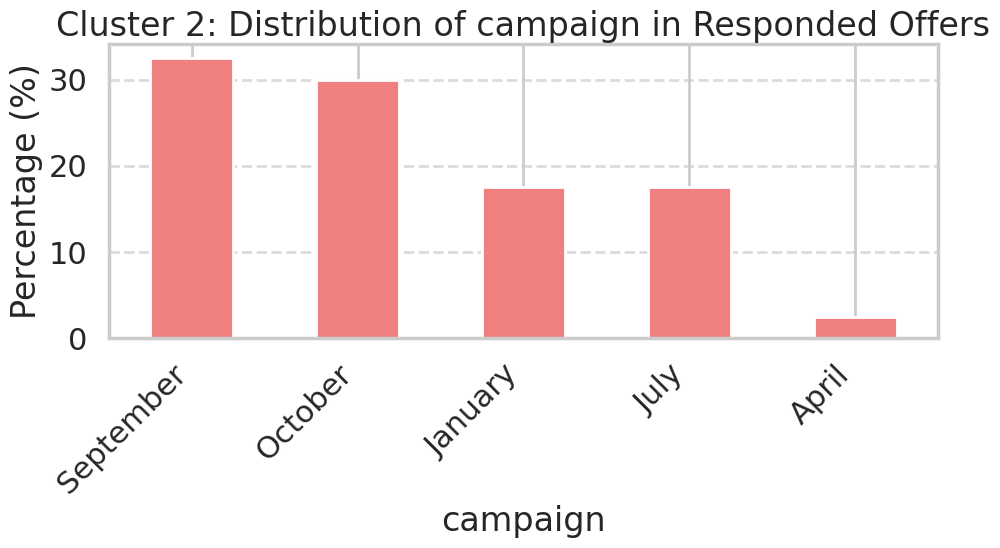

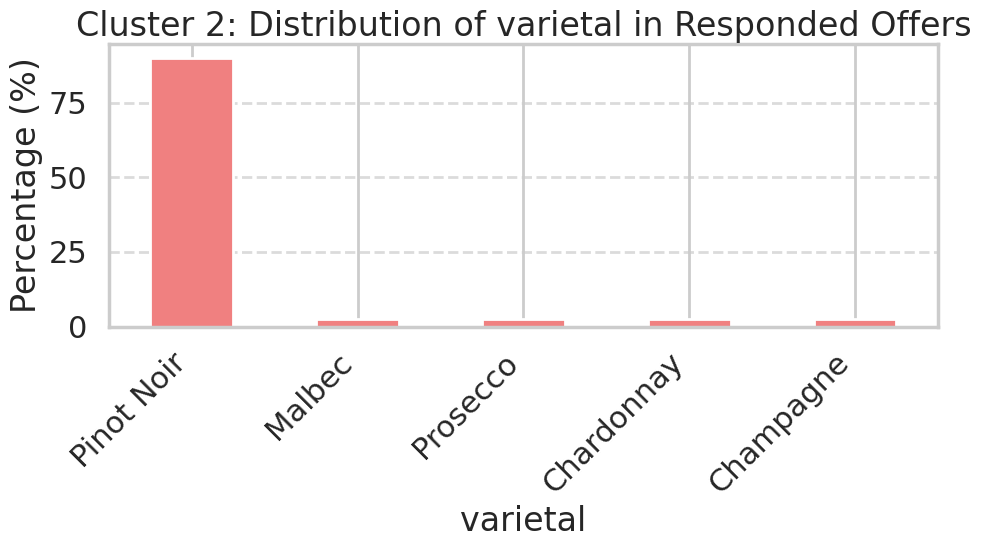

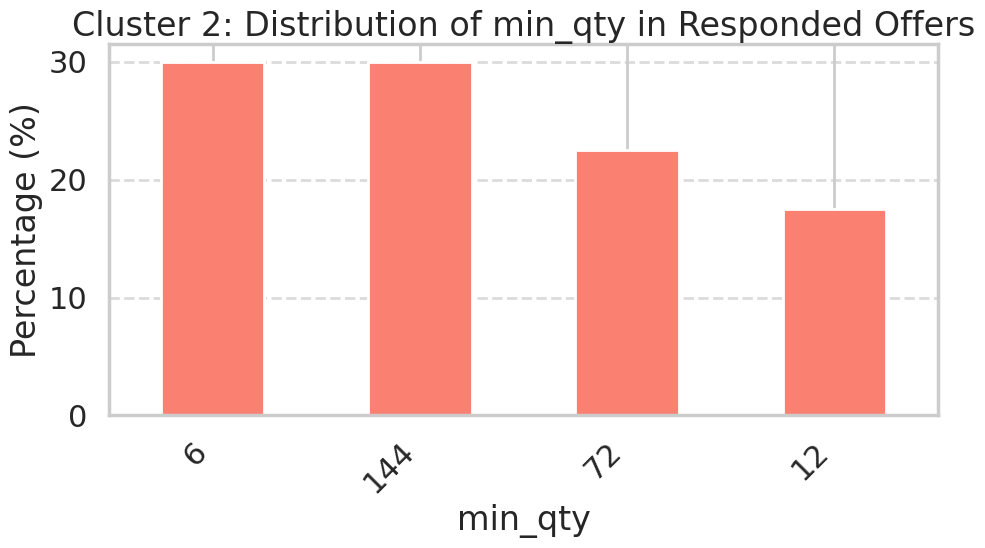

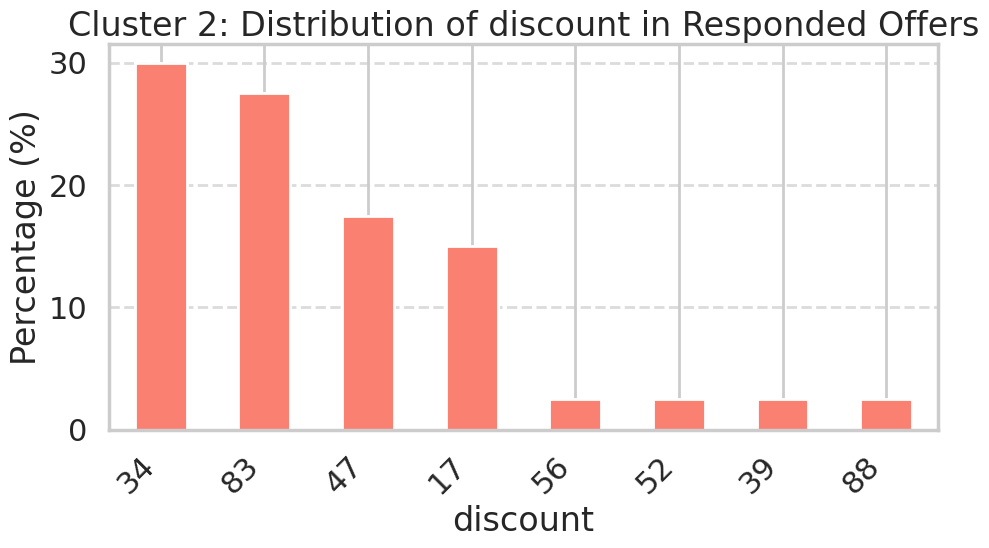

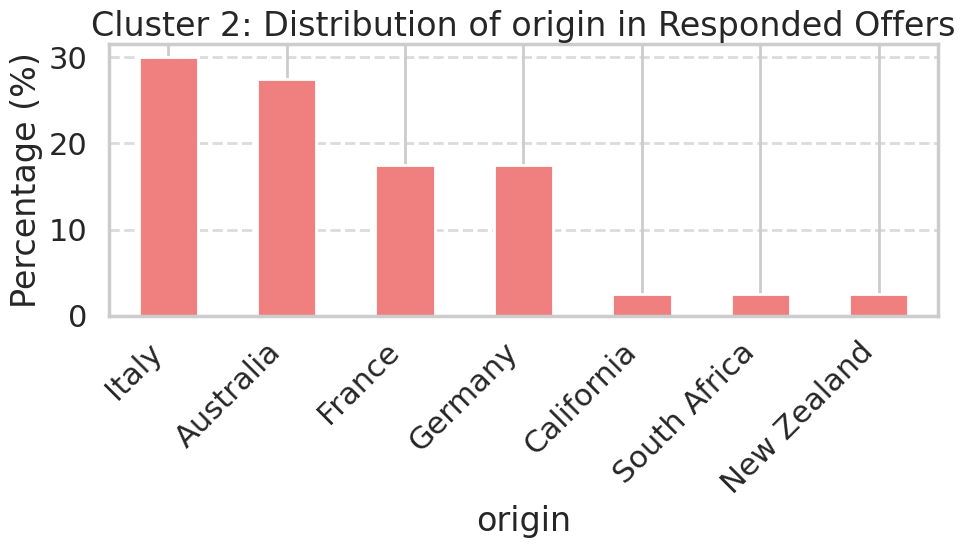

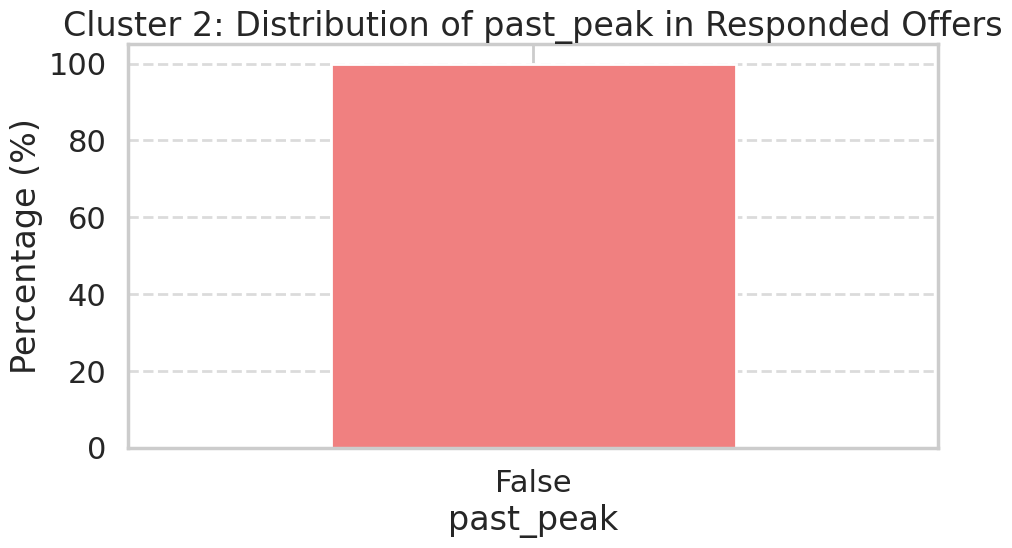

In [19]:
# Modify cell kkHjorzrO2WE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure final_df is available and correctly structured from previous steps.
# final_df contains: 'customer_name', 'offer_id', 'n', 'cluster_id',
# 'campaign', 'varietal', 'min_qty', 'discount', 'origin', 'past_peak'

features_to_analyze = ['campaign', 'varietal', 'min_qty', 'discount', 'origin', 'past_peak']
unique_clusters = sorted(final_df['cluster_id'].unique()) # Get the actual cluster IDs present

for cluster_id in unique_clusters:
    # Filter data for the current cluster
    cluster_data = final_df[final_df['cluster_id'] == cluster_id]
    num_customers_in_cluster = cluster_data['customer_name'].nunique()
    print(f"\n--- Analysis for Cluster ID: {cluster_id} (Total customers: {num_customers_in_cluster}) ---")

    for feature in features_to_analyze:
        plt.figure(figsize=(10, 6)) # Adjust figure size for better readability

        if feature in ['min_qty', 'discount']: # These were numerical, now treat as categorical for percentages
            # Get the counts of each category, normalize to percentage
            counts = cluster_data[feature].value_counts(normalize=True) * 100

            if counts.empty:
                plt.text(0.5, 0.5, f"No data for '{feature}' in this cluster.", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                plt.title(f'Cluster {cluster_id}: Distribution of {feature}')
                plt.xticks([])
                plt.yticks([])
            else:
                counts.plot(kind='bar', color='salmon')
                plt.ylabel('Percentage (%)')
                plt.title(f'Cluster {cluster_id}: Distribution of {feature} in Responded Offers')
                plt.xticks(rotation=45, ha='right')

        elif feature == 'past_peak': # Boolean feature, treat as categorical
            # Count occurrences of True/False and normalize to percentages
            counts = cluster_data[feature].value_counts(normalize=True) * 100
            if counts.empty:
                plt.text(0.5, 0.5, "No data for this feature in this cluster.", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                plt.title(f'Cluster {cluster_id}: Distribution of {feature}')
                plt.xticks([])
                plt.yticks([])
            else:
                counts.plot(kind='bar', color=['lightcoral', 'lightgreen'])
                plt.ylabel('Percentage (%)')
                plt.title(f'Cluster {cluster_id}: Distribution of {feature} in Responded Offers')
                plt.xticks(rotation=0) # No need to rotate for True/False

        else: # Categorical features: 'campaign', 'varietal', 'origin'
            # Get the counts of each category, normalize to percentage
            counts = cluster_data[feature].value_counts(normalize=True) * 100

            if counts.empty:
                plt.text(0.5, 0.5, "No data for this feature in this cluster.", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                plt.title(f'Cluster {cluster_id}: Distribution of {feature}')
                plt.xticks([])
                plt.yticks([])
            else:
                counts.plot(kind='bar', color='lightcoral')
                plt.ylabel('Percentage (%)')
                plt.title(f'Cluster {cluster_id}: Distribution of {feature} in Responded Offers')
                plt.xticks(rotation=45, ha='right')

        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

Cluster 0 appears to describe customers who are not looking to purchase wine in bulk, considering all the customers in this cluster chose offers with a minimum quantity of 6. Over 40% over them chose French wine and Espumante was the most popular variety for this cluster at just over 30%. There didn't appear to be much of a trend in seasonality for the month of the campaign, nor the discount on the wine. Over 80% of the customers chose fresh wine not past its peak.

Cluster 1 had offers from all months of the year with roughly a third choosing Champagne. These customers had nearly 80% of their purchases made on offers with a minimum quantity of 72 or 144, suggesting these were wealthier shoppers, restaurants, or any other demographic looking to buy wine in bulk quantities. Interestingly, this cluster also had over 40% of wine come from France. This would suggest that French wines are quite popular amongst the spread of buyers.

Cluster 2 had an overwhelming majority choose pinot noir covering over 80% of this cluster. The minimum quantity for this cluster had an even spread between low and high minimum quantity offers, suggesting this group is highly defined by the variety of wine.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

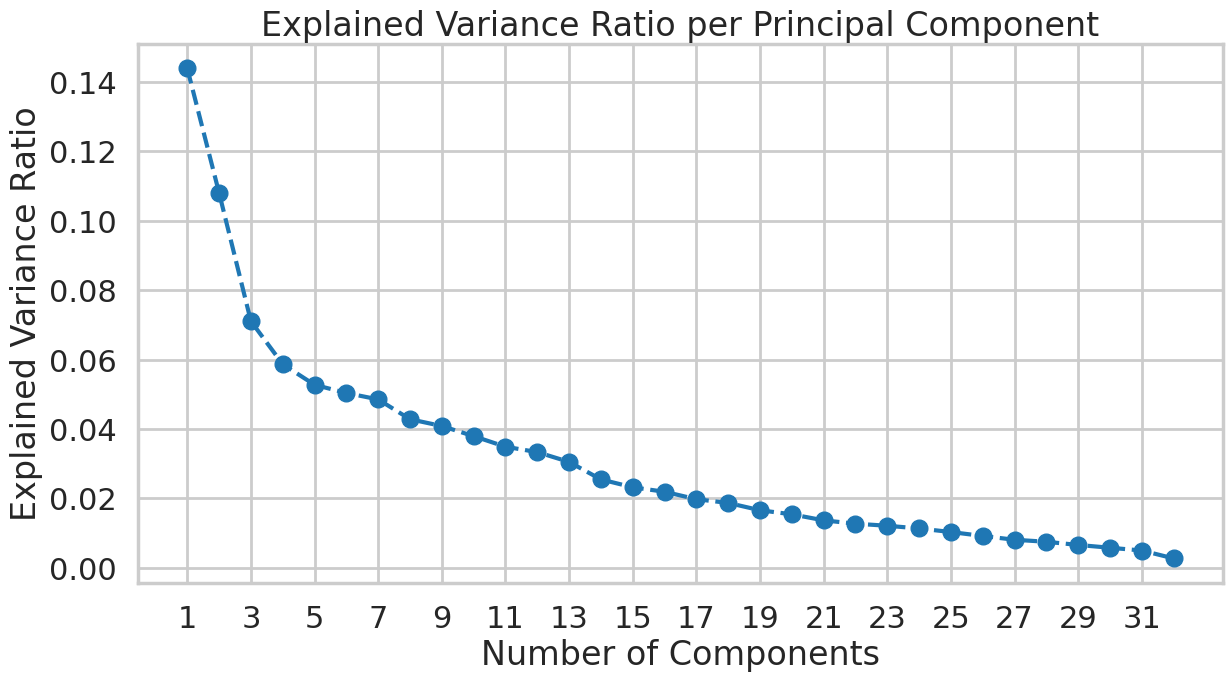

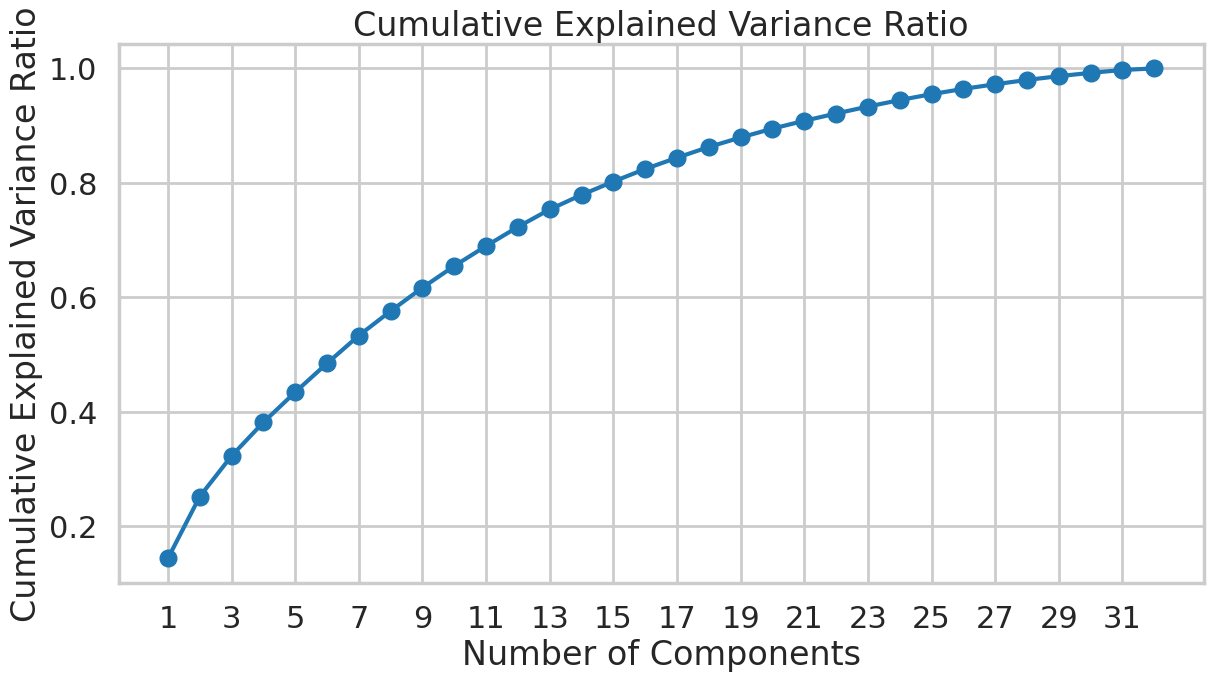


Based on the elbow method from the explained variance ratio plot, the optimal number of dimensions appears to be: 4


In [20]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
import matplotlib.pyplot as plt
import numpy as np

pca = sklearn.decomposition.PCA()
pca.fit(x_cols) # Corrected X to x_cols

# Calculate cumulative explained variance
cumsum_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance ratio per component
plt.figure(figsize=(14, 7)) # Increased figure width
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component')
plt.grid(True)
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1, 2)) # Label every other component
plt.show()

# Plot the cumulative explained variance
plt.figure(figsize=(14, 7)) # Increased figure width
plt.plot(range(1, len(cumsum_explained_variance) + 1), cumsum_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.xticks(np.arange(1, len(cumsum_explained_variance) + 1, 2)) # Label every other component
plt.show()

# Based on the plots, identify the elbow point. A common practice is to look
# for where the curve starts to flatten out significantly. For this dataset,
# the largest drop is around 2 or 3 components, and it starts to flatten after that.
# Visually, 3 or 4 could be considered elbow points where the gain in explained variance
# starts to diminish significantly. I will go with 4 for a good balance.
optimal_dimensions = 4
print(f"\nBased on the elbow method from the explained variance ratio plot, the optimal number of dimensions appears to be: {optimal_dimensions}")

Using the elbow method here on our PCA, we can conclude that 3 or 4 are both solid choices for the number of principal components that give the most explained variance before diminishing returns start to really take affect.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call.

Based on the analysis done on this wine dataset, we can conclude that it is most likely that customers will fall into one of 3 groups. We can confidently say this due to multiple methods confirming that these 3 clusters give the best defintion of groups with enough explained variance to keep each of the groups distinct from each other while also not overfitting to the dataset and creating too many subgroups that will not generalize to real world business decisions and future data. The business executives would likely find it wise to create tailored offerings that are built for the average individual in all of these groups.

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn.

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity.

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


Affinity Propagation: Cluster counts for various preference values
----------------------------------------------------
Preference = -5: Found 19 clusters.


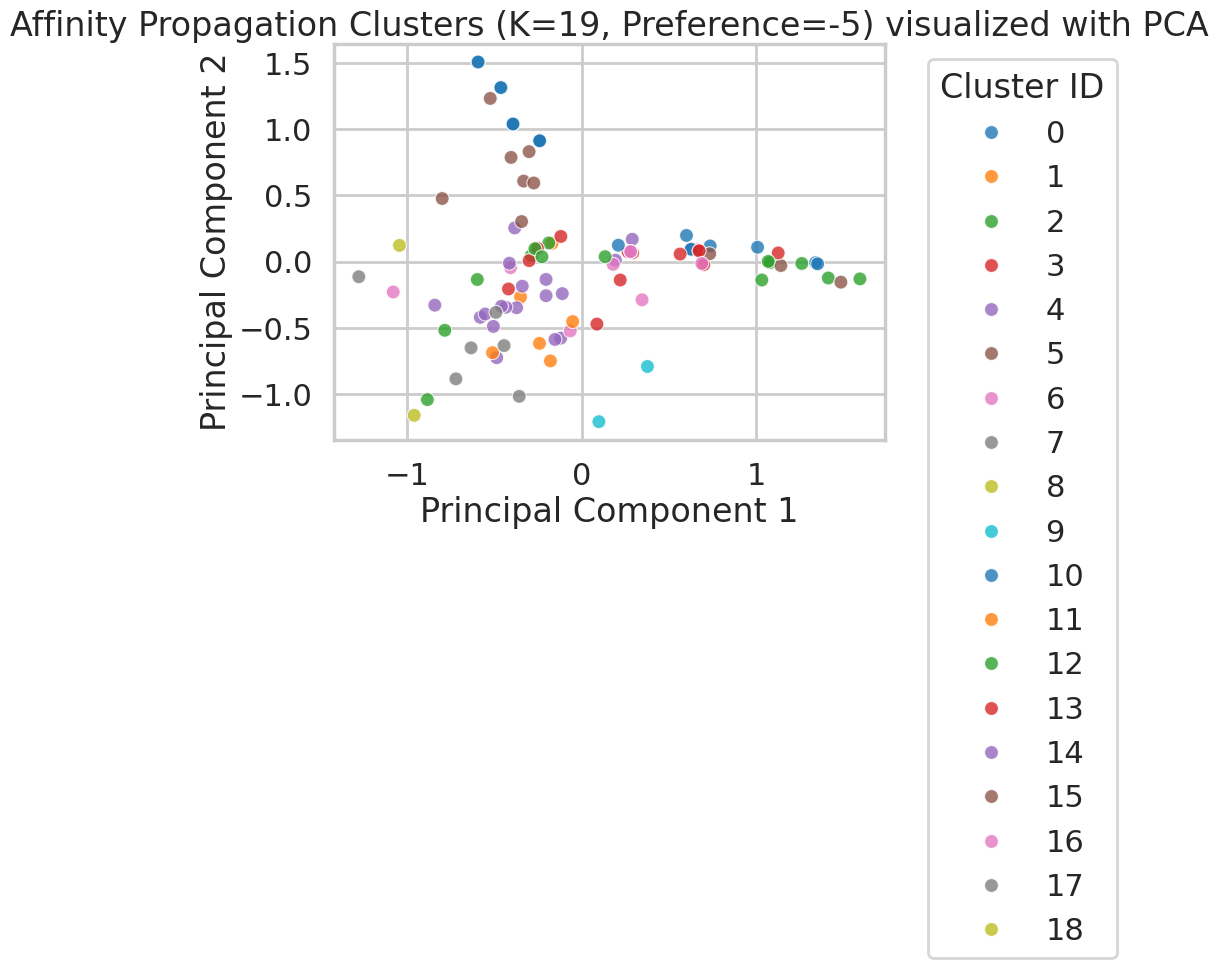

Preference = -10: Found 10 clusters.


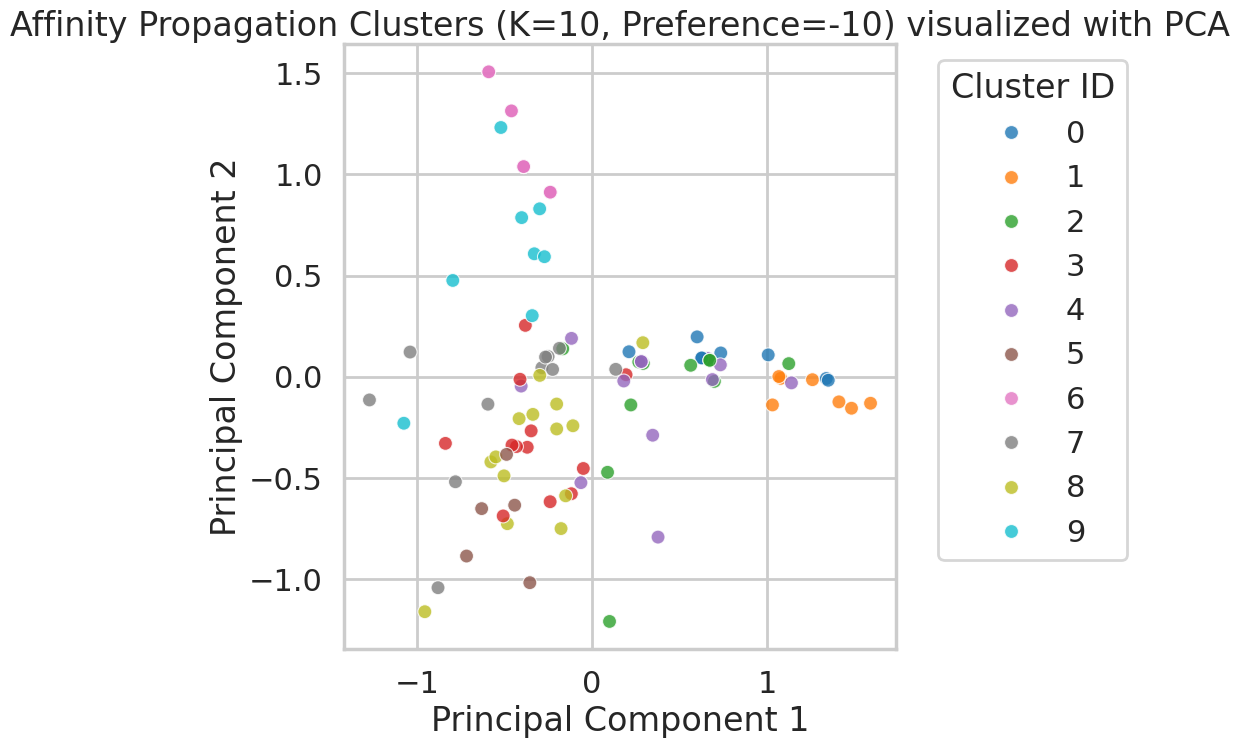

Preference = -20: Found 4 clusters.


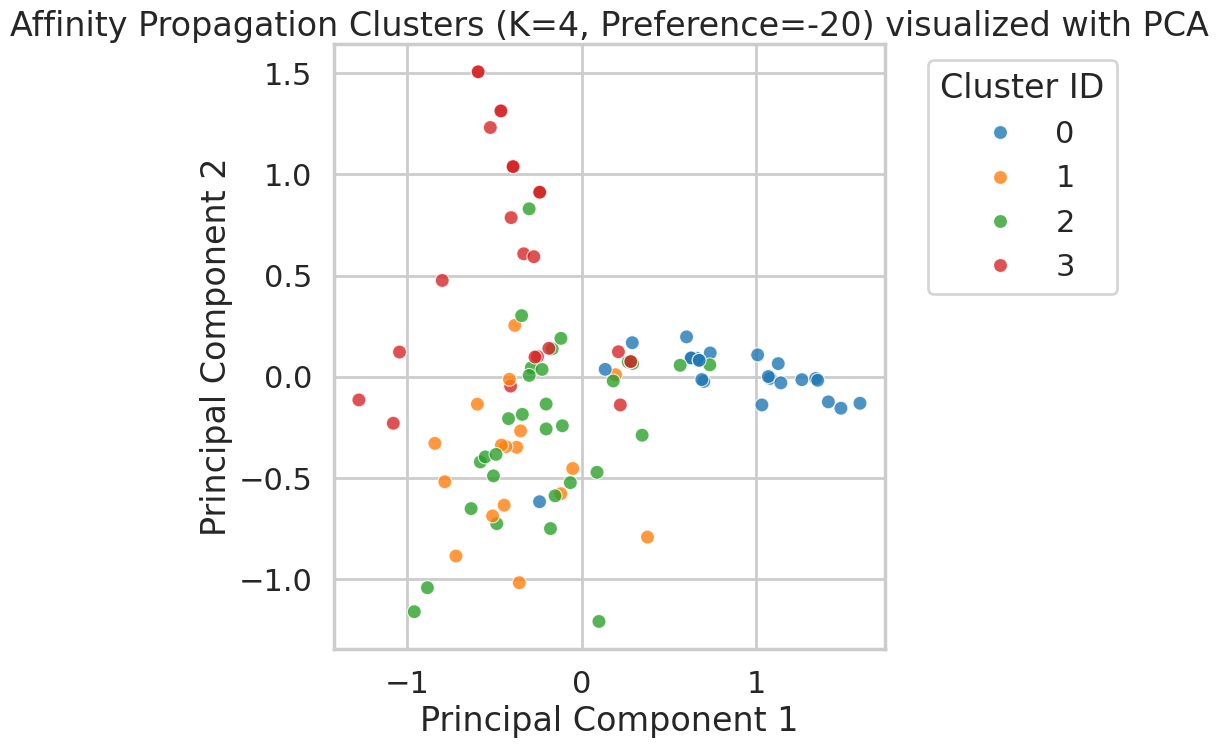

Preference = -30: Found 3 clusters.


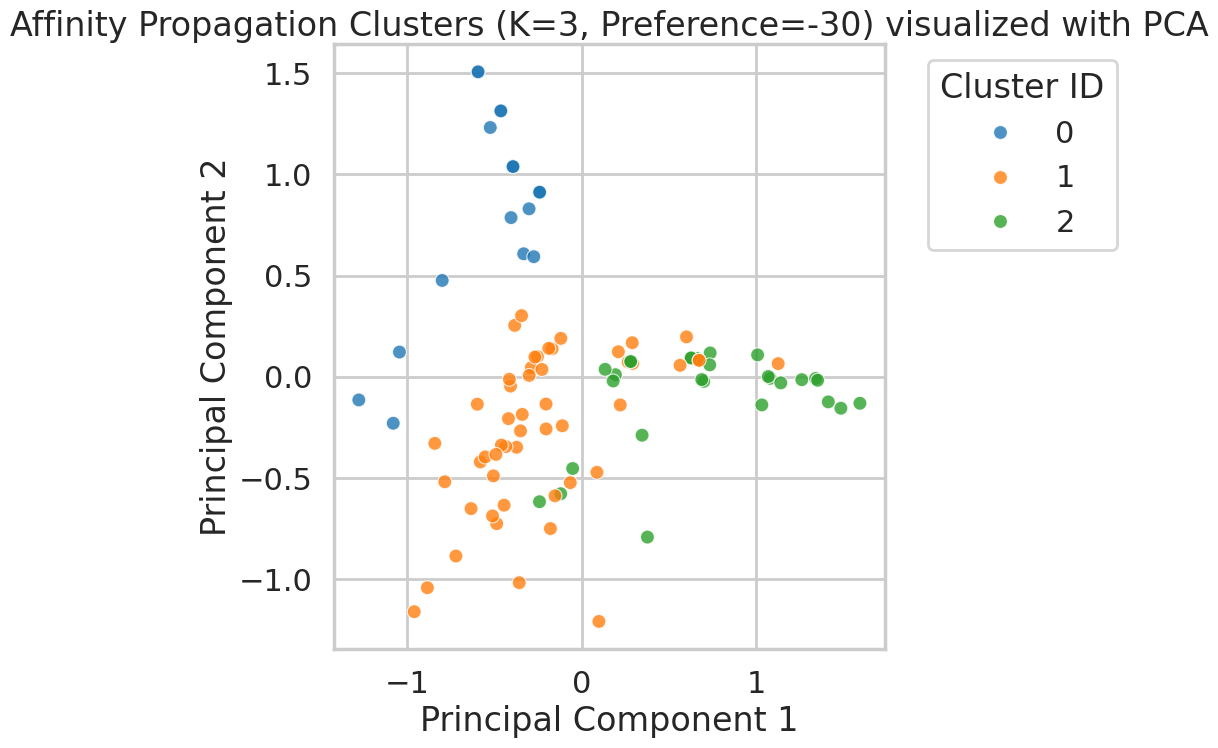

Preference = -50: Found 1 clusters.


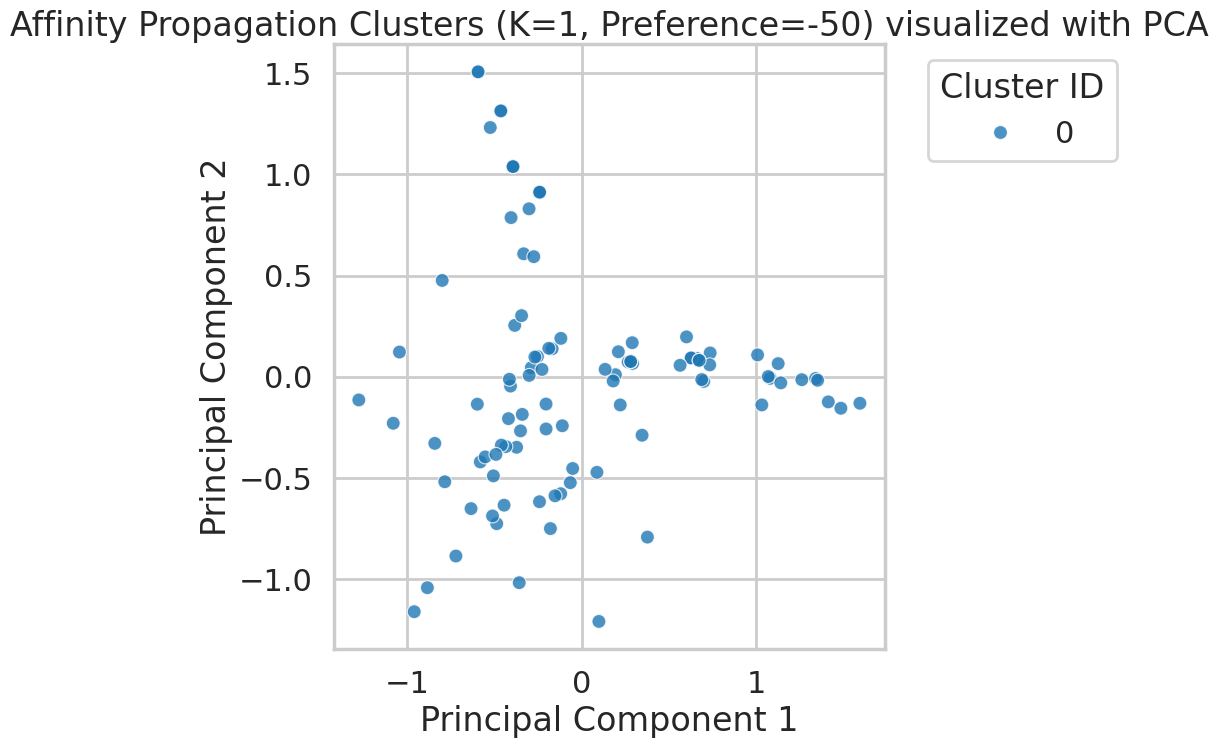

In [21]:
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define a range of preference values to test
preference_values = [-5, -10, -20, -30, -50]

print("Affinity Propagation: Cluster counts for various preference values")
print("----------------------------------------------------")

for pref in preference_values:
    # 1. Initialize an AffinityPropagation model with the current preference value
    affinity_propagation = AffinityPropagation(random_state=42, preference=pref)

    # 2. Fit the AffinityPropagation model to the x_cols data
    affinity_propagation.fit(x_cols)

    # Get the cluster labels
    ap_cluster_labels = affinity_propagation.labels_

    # Get the number of clusters found by Affinity Propagation
    # Ensure noise points (-1) are not counted as clusters
    n_clusters_ap = len(set(ap_cluster_labels)) - (1 if -1 in ap_cluster_labels else 0)

    print(f"Preference = {pref}: Found {n_clusters_ap} clusters.")

    # Create a pandas DataFrame containing customer_name, cluster_id, and PCA components
    cluster_viz_df_ap = pd.DataFrame({
        "customer_name": df['customer_name'], # Assuming 'df' DataFrame has 'customer_name' column
        "cluster_id": ap_cluster_labels,
        "x": pca_components[:, 0],
        "y": pca_components[:, 1]
    })

    # Generate a scatter plot for the current preference value
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=cluster_viz_df_ap,
        x="x",
        y="y",
        hue="cluster_id",
        palette="tab10", # Use a distinct color palette for many clusters
        s=100,
        alpha=0.8
    )
    plt.title(f"Affinity Propagation Clusters (K={n_clusters_ap}, Preference={pref}) visualized with PCA")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Removed silhouette score calculation as per user request.

Here we can see that after messing around with our preference value, we landed on an affinity propogation output that gave us 3 clusters, and we can see that they are similar to the clusters produced by our KMeans algorithm. Just judging visually, I would want to say that the affinity propogation is less likely to be as useful compared to the KMeans due to the overlapping of clusters, but its possible further analysis on the characteristics of the clusters may prove this clustering to be more useful.

In [22]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import pandas as pd

# 2. Initialize a SpectralClustering model
# Using best_k = 3 from previous K-Means analysis
n_clusters_sc = best_k # Using the best_k derived from Elbow method
spectral_clustering = SpectralClustering(n_clusters=n_clusters_sc, assign_labels='kmeans', random_state=42)

# 3. Fit the SpectralClustering model to the x_cols data
sc_cluster_labels = spectral_clustering.fit_predict(x_cols)

print(f"Spectral Clustering found {n_clusters_sc} clusters.")

# 4. Calculate the silhouette score
# The silhouette score is defined only if the number of labels is between 1 and n_samples - 1
if n_clusters_sc > 1 and n_clusters_sc < len(x_cols):
    sc_silhouette_avg = silhouette_score(x_cols, sc_cluster_labels)
    print(f"The average silhouette_score for Spectral Clustering is: {sc_silhouette_avg:.3f}")
else:
    print("Silhouette score cannot be calculated for the given number of clusters or data size.")

Spectral Clustering found 3 clusters.
The average silhouette_score for Spectral Clustering is: 0.106


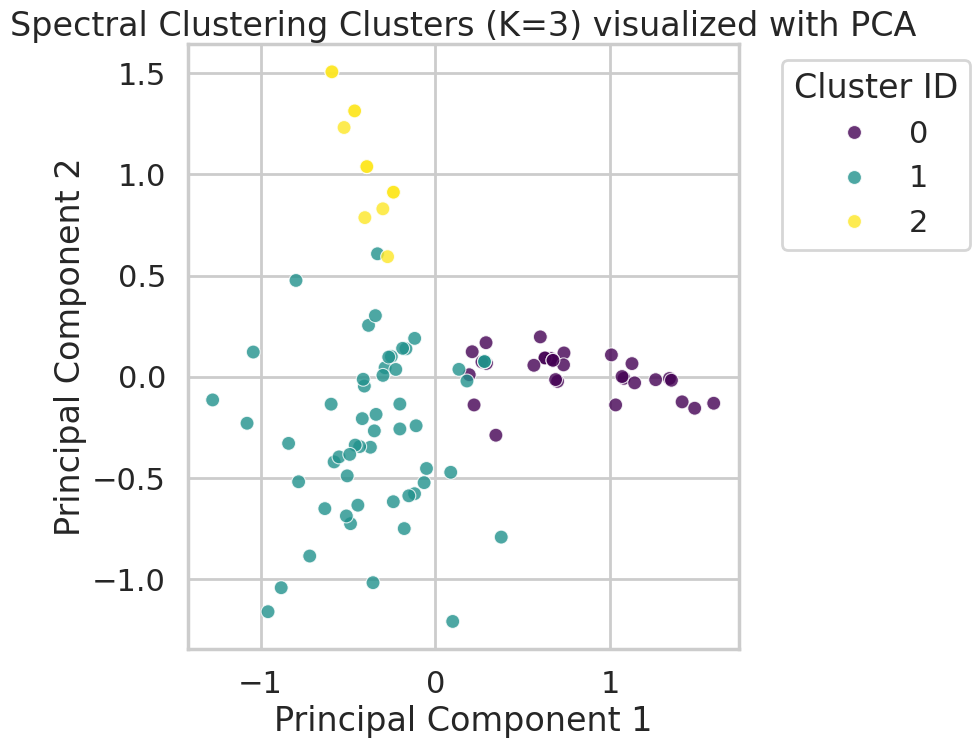

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 5. Create a pandas DataFrame containing customer_name, cluster_id, and PCA components
# Ensure df and pca_components are available from previous steps
cluster_viz_df_sc = pd.DataFrame({
    "customer_name": df['customer_name'], # Assuming 'df' DataFrame has 'customer_name' column
    "cluster_id": sc_cluster_labels,
    "x": pca_components[:, 0],
    "y": pca_components[:, 1]
})

# 6. Generate a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=cluster_viz_df_sc,
    x="x",
    y="y",
    hue="cluster_id",
    palette="viridis", # Use a distinct color palette
    s=100,
    alpha=0.8
)
plt.title(f"Spectral Clustering Clusters (K={n_clusters_sc}) visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Here we can see that the spectral clustering algorithm creates very similar clusterings compared to our KMeans clustering. I would still lean towards the KMeans clustering being more accurate for this data set as spectral clustering is more so designed for concave shaped clusters that are difficult to create with KMeans.

In [24]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import pandas as pd

# 2. Initialize an AgglomerativeClustering model
# Using best_k = 3 for consistency with previous K-Means analysis
n_clusters_agg = best_k # Using the best_k derived from Elbow method
agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters_agg)

# 3. Fit the AgglomerativeClustering model to the x_cols data to obtain cluster labels
agg_cluster_labels = agglomerative_clustering.fit_predict(x_cols)

print(f"Agglomerative Clustering found {n_clusters_agg} clusters.")

# 4. Calculate the silhouette score
# The silhouette score is defined only if the number of labels is between 1 and n_samples - 1
if n_clusters_agg > 1 and n_clusters_agg < len(x_cols):
    agg_silhouette_avg = silhouette_score(x_cols, agg_cluster_labels)
    print(f"The average silhouette_score for Agglomerative Clustering is: {agg_silhouette_avg:.3f}")
else:
    print("Silhouette score cannot be calculated for the given number of clusters or data size.")

Agglomerative Clustering found 3 clusters.
The average silhouette_score for Agglomerative Clustering is: 0.116


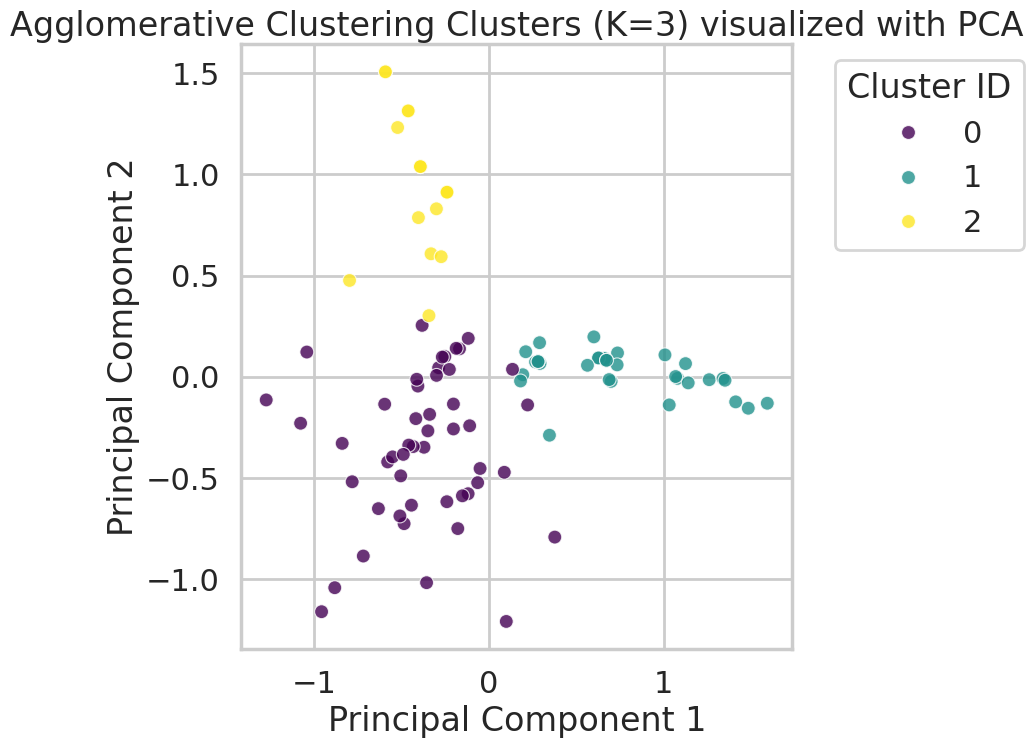

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 5. Create a pandas DataFrame containing customer_name, cluster_id, and PCA components
# Ensure df and pca_components are available from previous steps
cluster_viz_df_agg = pd.DataFrame({
    "customer_name": df['customer_name'], # Assuming 'df' DataFrame has 'customer_name' column
    "cluster_id": agg_cluster_labels,
    "x": pca_components[:, 0],
    "y": pca_components[:, 1]
})

# 6. Generate a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=cluster_viz_df_agg,
    x="x",
    y="y",
    hue="cluster_id",
    palette="viridis", # Use a distinct color palette
    s=100,
    alpha=0.8
)
plt.title(f"Agglomerative Clustering Clusters (K={n_clusters_agg}) visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Again our agglomerative clustering gives a very similar result to our KMeans clustering. Choosing which one is truly most accurate to the real world clustering of our data would involve comparing and contrasting the two in depth, and realistically, using either would give very similar results in terms of the real world actionable business decisions made based on the generated clusters.

In [48]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

# 1. Define a range of eps values to explore
# Starting from 0.1 to 2.0 with steps of 0.1
eps_values = np.arange(0.1, 2.1, 0.1)

# 2. Define a range of min_samples values to explore
# Starting from 2 to 10
min_samples_values = range(2, 15)

# 3. Initialize an empty list to store the outcomes
dbscan_results = []

print("Iterating through DBSCAN parameters on PCA components...")

# 4. Create nested loops to iterate through all combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # a. Initialize a DBSCAN model
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # b. Fit the DBSCAN model to the PCA components data
        # IMPORTANT: Using pca_components instead of x_cols as requested
        dbscan_labels = dbscan.fit_predict(pca_components)

        # c. Calculate the number of unique clusters found, excluding noise points (-1)
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

        # d. Append a dictionary with the results to the list
        dbscan_results.append({
            'eps': round(eps, 2), # Round eps for cleaner display
            'min_samples': min_samples,
            'n_clusters': n_clusters
        })

# 5. Convert the dbscan_results list into a pandas DataFrame
dbscan_df = pd.DataFrame(dbscan_results)

# 6. Display the head of the dbscan_df DataFrame
print("\nFirst few rows of DBSCAN results DataFrame (on PCA components):")
display(dbscan_df.head())

print("\nShape of DBSCAN results DataFrame:", dbscan_df.shape)
print("Unique number of clusters found:", dbscan_df['n_clusters'].nunique())


Iterating through DBSCAN parameters on PCA components...

First few rows of DBSCAN results DataFrame (on PCA components):


eps  min_samples  n_clusters
0  0.1            2          17
1  0.1            3          10
2  0.1            4           5
3  0.1            5           4
4  0.1            6           3


Shape of DBSCAN results DataFrame: (260, 3)
Unique number of clusters found: 10


Found 6 DBSCAN parameter combinations that resulted in 3 actual clusters.

Plotting for eps=0.1, min_samples=6: 3 actual clusters, 74 noise points


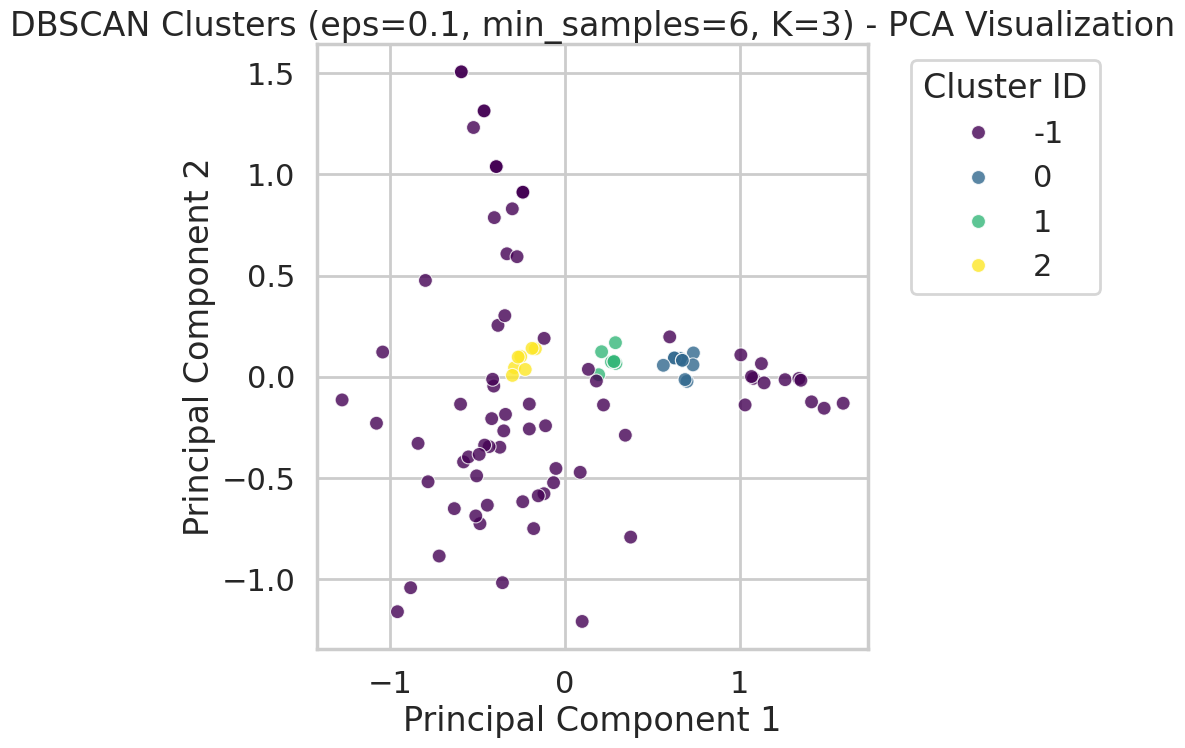

Plotting for eps=0.2, min_samples=9: 3 actual clusters, 51 noise points


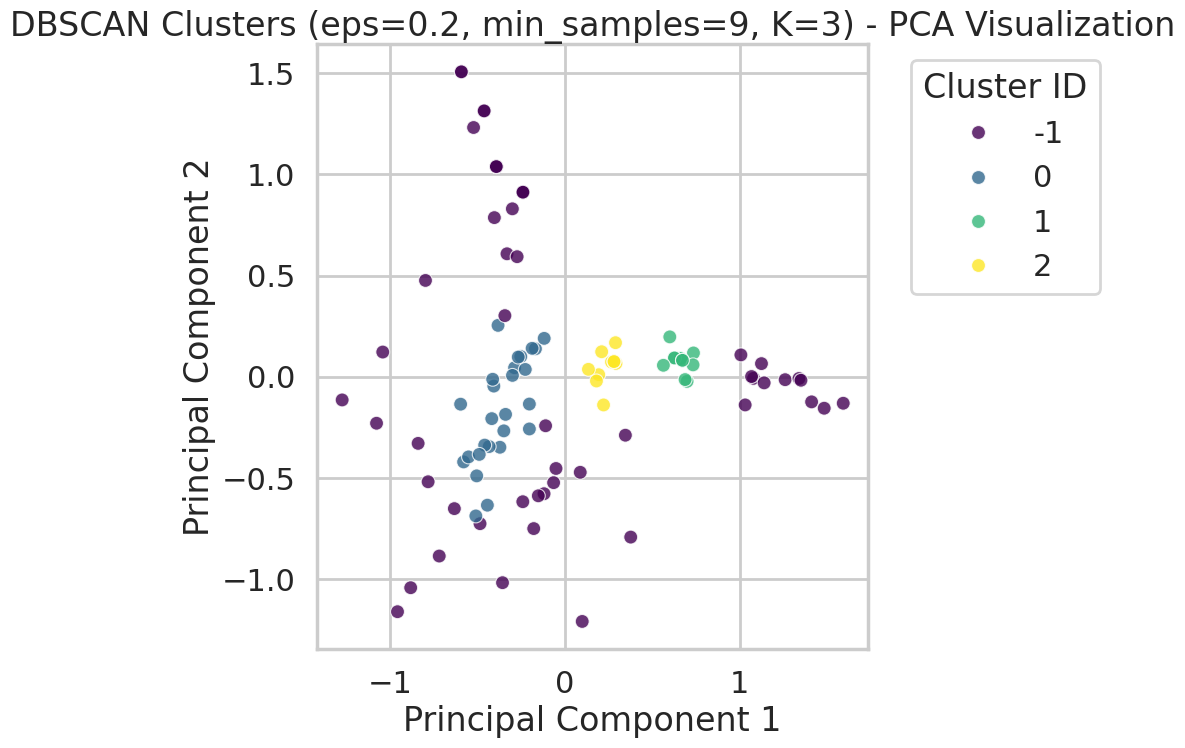

Plotting for eps=0.2, min_samples=10: 3 actual clusters, 53 noise points


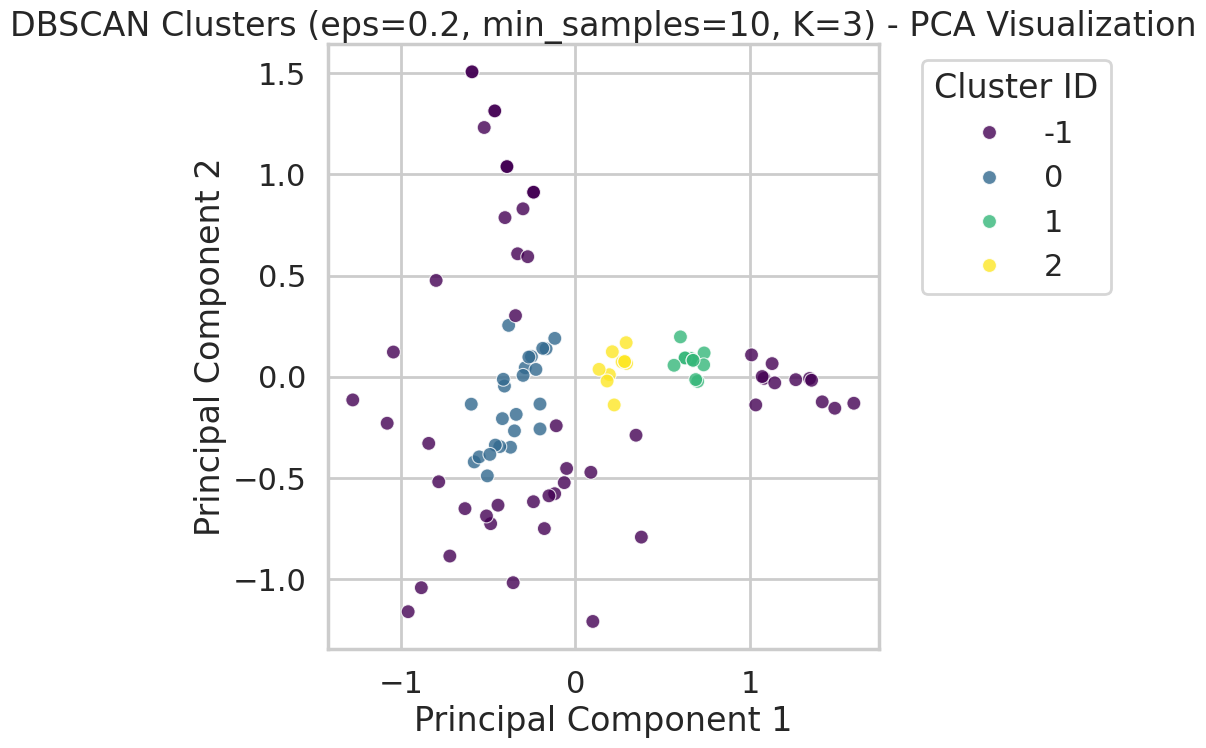

Plotting for eps=0.2, min_samples=11: 3 actual clusters, 59 noise points


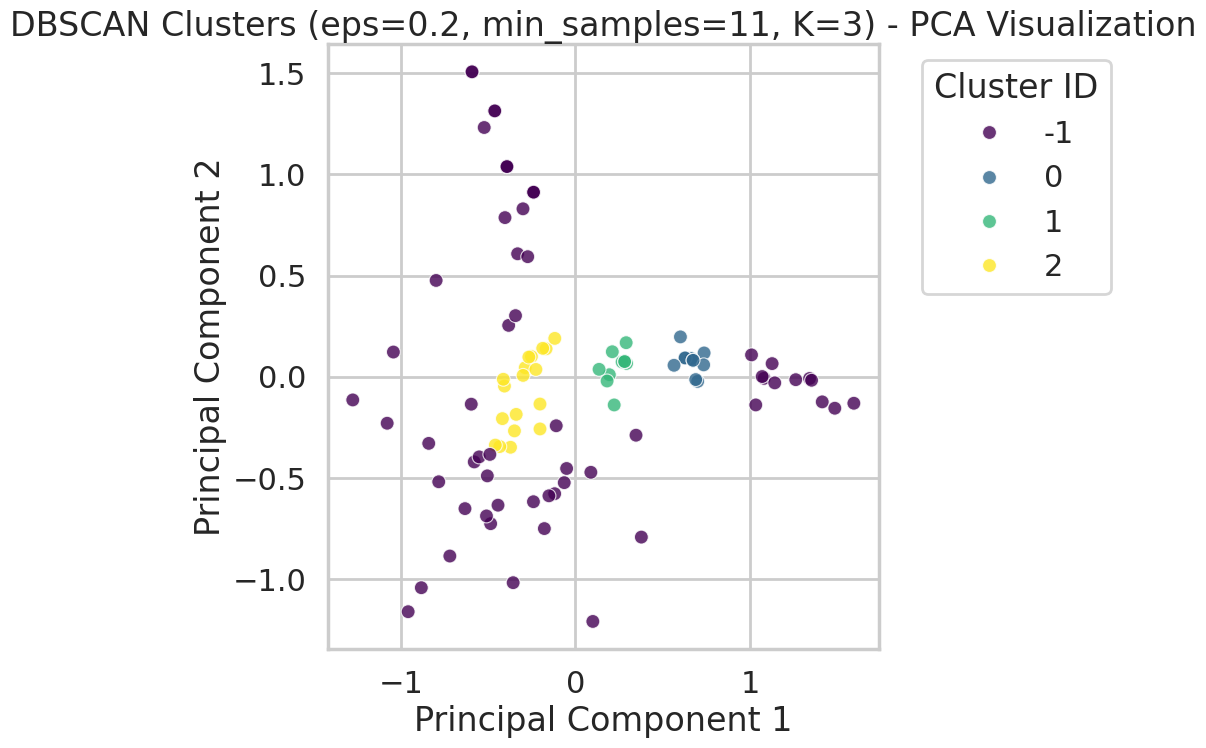

Plotting for eps=0.3, min_samples=10: 3 actual clusters, 13 noise points


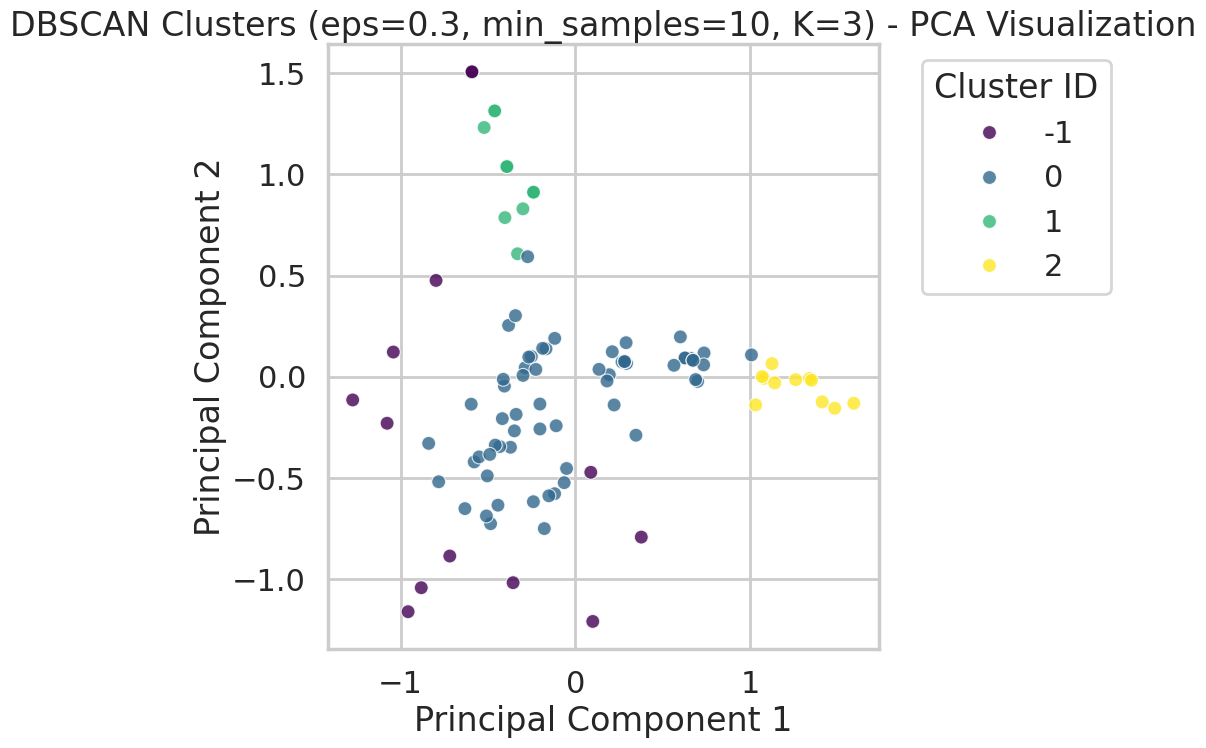

Plotting for eps=0.3, min_samples=11: 3 actual clusters, 15 noise points


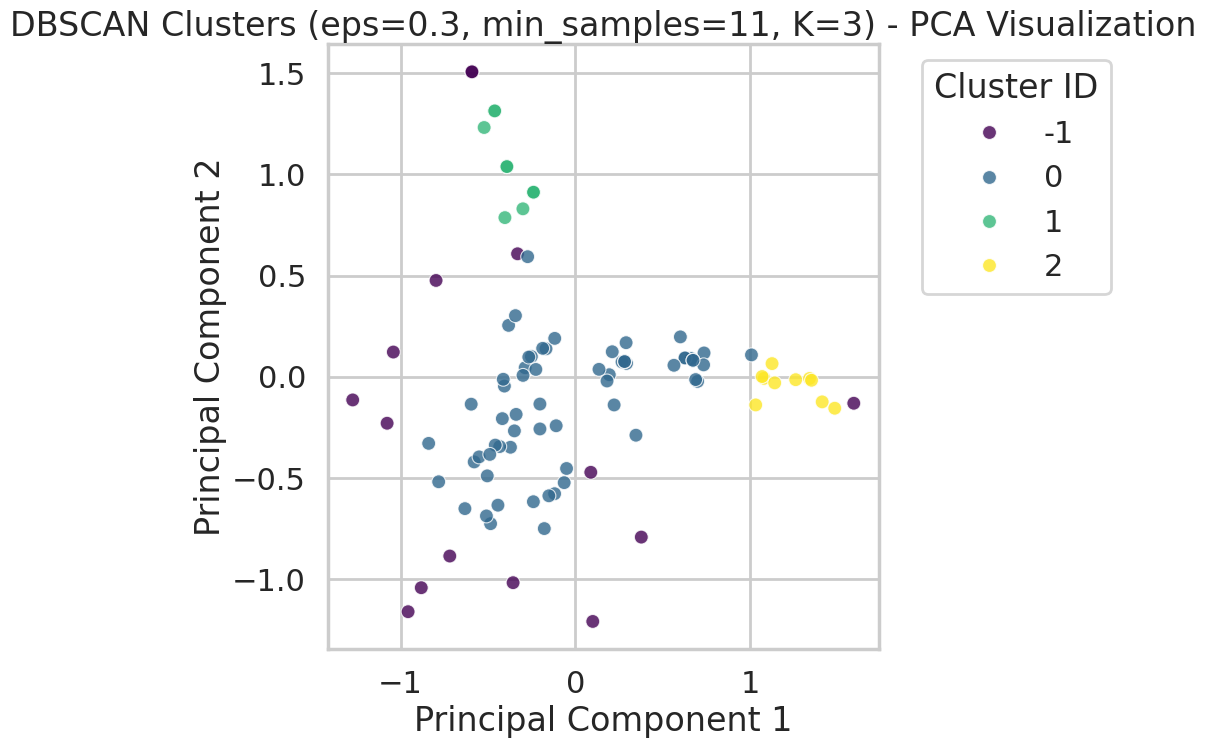

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import DBSCAN

# Ensure dbscan_df and pca_components are available from previous steps

# Filter dbscan_df to find combinations that resulted in exactly 3 clusters (excluding noise)
three_cluster_combinations = dbscan_df[dbscan_df['n_clusters'] == 3]

print(f"Found {len(three_cluster_combinations)} DBSCAN parameter combinations that resulted in 3 actual clusters.\n")

if not three_cluster_combinations.empty:
    for index, row in three_cluster_combinations.iterrows():
        eps = row['eps']
        min_samples = int(row['min_samples']) # Cast to int to resolve the error

        # Re-run DBSCAN with these specific parameters on pca_components
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(pca_components)

        # Get the number of clusters and noise points for this specific run
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise_points = list(dbscan_labels).count(-1)

        print(f"Plotting for eps={eps}, min_samples={min_samples}: {n_clusters} actual clusters, {n_noise_points} noise points")

        # Create a pandas DataFrame for plotting
        plot_df_dbscan = pd.DataFrame({
            "customer_name": df['customer_name'], # Assuming 'df' DataFrame has 'customer_name' column
            "cluster_id": dbscan_labels,
            "x": pca_components[:, 0],
            "y": pca_components[:, 1]
        })

        # Generate a scatter plot
        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            data=plot_df_dbscan,
            x="x",
            y="y",
            hue="cluster_id",
            palette='viridis', # Use a distinct color palette
            s=100,
            alpha=0.8
        )
        plt.title(f"DBSCAN Clusters (eps={eps}, min_samples={min_samples}, K=3) - PCA Visualization")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("No DBSCAN parameter combinations resulted in exactly 3 actual clusters.")


After some time fiddling with the parameters of the DBSCAN algorithm, I was able to produce a few output clusterings that were similar to those produced by the other algorithms. DBSCAN filters out outliers as noise as seen in the -1 cluster in the above plots. After working with this data set, I think truly the best clustering algorithm would be a decision tree due to their being a single large cluster with two long arms coming out that can be neatly seperated into three distinct clusters. DBSCAN is not ideal here due to the high dimensionality of our x_cols data, so I ended up having to use it on the dimensionality reduced PCA version, as using x_cols resulted in over half of the data being labeled as noise.

In conclusion, I think our best clustering method ended up being the most simple, KMeans, due to the simple shapes of our clusters. The analysis I performed on the characteristics of the clusters made logical sense as well, and the rest of the algorithms after were simply overtly complex for this data set and better suited to data with much more difficult to unpack relationships and clustering.

**NOTE: This project was completed with the assistance of Google Colab and its built in Gemini AI.**